# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')

ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [5]:
croot_data = pd.DataFrame()

for i in range(2007, 2021):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)

def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice ,year)
# calculate_roster_talent("Alabama", 2020)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44156


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [8]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [9]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
#     pbp_data.EqPPP.fillna(value=0, inplace=True)

In [10]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449


In [11]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [12]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True


In [13]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data.iloc[max(min(100, int(kick_yardline + distance)), 0)].ep - ep_data.iloc[max(min(100, kick_yardline), 0)].ep - ep_data.iloc[max(min(100, int(return_yards)), 0)].ep

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
#     print(team_stat_pack.IsoPPP)
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSRDiff * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)
def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.574919,-1.574919,-0.181874,0.5748,1.574919,1.574919,-0.181874,0.5748,5.101903,0.205034
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.574919,1.574919,0.181874,-0.5748,-1.574919,-1.574919,0.181874,-0.5748,4.896869,-0.205034


In [14]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.830347,4.960309,5.101903,0.205034
1,Virginia Tech,4.857978,4.949548,4.613372,5.169368,5.027691,4.896869,-0.205034


In [15]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if ((x == "San JosÃÂÃÂ© State") | (x == "San JosÃÂ© State")) else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 4504 box score groups by GameID.
[1/4504] Updating 5FR Margin for game_id 322430238...
[1/4504] Updated 5FR Margin for game_id 322430238.
[2/4504] Updating 5FR Margin for game_id 322430242...
[2/4504] Updated 5FR Margin for game_id 322430242.
[3/4504] Updating 5FR Margin for game_id 322432006...
[3/4504] Updated 5FR Margin for game_id 322432006.
[4/4504] Updating 5FR Margin for game_id 322432050...
[4/4504] Updated 5FR Margin for game_id 322432050.
[5/4504] Updating 5FR Margin for game_id 322432439...
[5/4504] Updated 5FR Margin for game_id 322432439.
[6/4504] Updating 5FR Margin for game_id 322440024...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[6/4504] Updated 5FR Margin for game_id 322440024.
[7/4504] Updating 5FR Margin for game_id 322442633...
[7/4504] Updated 5FR Margin for game_id 322442633.
[8/4504] Updating 5FR Margin for game_id 322450002...
[8/4504] Updated 5FR Margin for game_id 322450002.
[9/4504] Updating 5FR Margin for game_id 322450005...
[9/4504] Updated 5FR Margin for game_id 322450005.
[10/4504] Updating 5FR Margin for game_id 322450012...
[10/4504] Updated 5FR Margin for game_id 322450012.
[11/4504] Updating 5FR Margin for game_id 322450025...
[11/4504] Updated 5FR Margin for game_id 322450025.
[12/4504] Updating 5FR Margin for game_id 322450030...
[12/4504] Updated 5FR Margin for game_id 322450030.
[13/4504] Updating 5FR Margin for game_id 322450038...
[13/4504] Updated 5FR Margin for game_id 322450038.
[14/4504] Updating 5FR Margin for game_id 322450057...
[14/4504] Updated 5FR Margin for game_id 322450057.
[15/4504] Updating 5FR Margin for game_id 322450061...
[15/4504] Updated 5FR Margin for game_id 322

[88/4504] Updated 5FR Margin for game_id 322590145.
[89/4504] Updating 5FR Margin for game_id 322590158...
[89/4504] Updated 5FR Margin for game_id 322590158.
[90/4504] Updating 5FR Margin for game_id 322590194...
[90/4504] Updated 5FR Margin for game_id 322590194.
[91/4504] Updating 5FR Margin for game_id 322590197...
[91/4504] Updated 5FR Margin for game_id 322590197.
[92/4504] Updating 5FR Margin for game_id 322590213...
[92/4504] Updated 5FR Margin for game_id 322590213.
[93/4504] Updating 5FR Margin for game_id 322590221...
[93/4504] Updated 5FR Margin for game_id 322590221.
[94/4504] Updating 5FR Margin for game_id 322590235...
[94/4504] Updated 5FR Margin for game_id 322590235.
[95/4504] Updating 5FR Margin for game_id 322590254...
[95/4504] Updated 5FR Margin for game_id 322590254.
[96/4504] Updating 5FR Margin for game_id 322590275...
[96/4504] Updated 5FR Margin for game_id 322590275.
[97/4504] Updating 5FR Margin for game_id 322590276...
[97/4504] Updated 5FR Margin for game

[174/4504] Updated 5FR Margin for game_id 322732309.
[175/4504] Updating 5FR Margin for game_id 322732390...
[175/4504] Updated 5FR Margin for game_id 322732390.
[176/4504] Updating 5FR Margin for game_id 322732509...
[176/4504] Updated 5FR Margin for game_id 322732509.
[177/4504] Updating 5FR Margin for game_id 322732567...
[177/4504] Updated 5FR Margin for game_id 322732567.
[178/4504] Updating 5FR Margin for game_id 322732572...
[178/4504] Updated 5FR Margin for game_id 322732572.
[179/4504] Updating 5FR Margin for game_id 322732711...
[179/4504] Updated 5FR Margin for game_id 322732711.
[180/4504] Updating 5FR Margin for game_id 322780254...
[180/4504] Updated 5FR Margin for game_id 322780254.
[181/4504] Updating 5FR Margin for game_id 322782116...
[181/4504] Updated 5FR Margin for game_id 322782116.
[182/4504] Updating 5FR Margin for game_id 322782229...
[182/4504] Updated 5FR Margin for game_id 322782229.
[183/4504] Updating 5FR Margin for game_id 322790183...
[183/4504] Updated 

[254/4504] Updated 5FR Margin for game_id 322872116.
[255/4504] Updating 5FR Margin for game_id 322872229...
[255/4504] Updated 5FR Margin for game_id 322872229.
[256/4504] Updating 5FR Margin for game_id 322872305...
[256/4504] Updated 5FR Margin for game_id 322872305.
[257/4504] Updating 5FR Margin for game_id 322872348...
[257/4504] Updated 5FR Margin for game_id 322872348.
[258/4504] Updating 5FR Margin for game_id 322872433...
[258/4504] Updated 5FR Margin for game_id 322872433.
[259/4504] Updating 5FR Margin for game_id 322872459...
[259/4504] Updated 5FR Margin for game_id 322872459.
[260/4504] Updating 5FR Margin for game_id 322872509...
[260/4504] Updated 5FR Margin for game_id 322872509.
[261/4504] Updating 5FR Margin for game_id 322872641...
[261/4504] Updated 5FR Margin for game_id 322872641.
[262/4504] Updating 5FR Margin for game_id 322872751...
[262/4504] Updated 5FR Margin for game_id 322872751.
[263/4504] Updating 5FR Margin for game_id 322900249...
[263/4504] Updated 

[331/4504] Updated 5FR Margin for game_id 323010166.
[332/4504] Updating 5FR Margin for game_id 323010167...
[332/4504] Updated 5FR Margin for game_id 323010167.
[333/4504] Updating 5FR Margin for game_id 323010189...
[333/4504] Updated 5FR Margin for game_id 323010189.
[334/4504] Updating 5FR Margin for game_id 323010193...
[334/4504] Updated 5FR Margin for game_id 323010193.
[335/4504] Updating 5FR Margin for game_id 323010197...
[335/4504] Updated 5FR Margin for game_id 323010197.
[336/4504] Updating 5FR Margin for game_id 323010201...
[336/4504] Updated 5FR Margin for game_id 323010201.
[337/4504] Updating 5FR Margin for game_id 323010213...
[337/4504] Updated 5FR Margin for game_id 323010213.
[338/4504] Updating 5FR Margin for game_id 323010221...
[338/4504] Updated 5FR Margin for game_id 323010221.
[339/4504] Updating 5FR Margin for game_id 323010238...
[339/4504] Updated 5FR Margin for game_id 323010238.
[340/4504] Updating 5FR Margin for game_id 323010242...
[340/4504] Updated 

[412/4504] Updated 5FR Margin for game_id 323150201.
[413/4504] Updating 5FR Margin for game_id 323150218...
[413/4504] Updated 5FR Margin for game_id 323150218.
[414/4504] Updating 5FR Margin for game_id 323150228...
[414/4504] Updated 5FR Margin for game_id 323150228.
[415/4504] Updating 5FR Margin for game_id 323150248...
[415/4504] Updated 5FR Margin for game_id 323150248.
[416/4504] Updating 5FR Margin for game_id 323150249...
[416/4504] Updated 5FR Margin for game_id 323150249.
[417/4504] Updating 5FR Margin for game_id 323150251...
[417/4504] Updated 5FR Margin for game_id 323150251.
[418/4504] Updating 5FR Margin for game_id 323150258...
[418/4504] Updated 5FR Margin for game_id 323150258.
[419/4504] Updating 5FR Margin for game_id 323150264...
[419/4504] Updated 5FR Margin for game_id 323150264.
[420/4504] Updating 5FR Margin for game_id 323150326...
[420/4504] Updated 5FR Margin for game_id 323150326.
[421/4504] Updating 5FR Margin for game_id 323150333...
[421/4504] Updated 

[491/4504] Updated 5FR Margin for game_id 323290135.
[492/4504] Updating 5FR Margin for game_id 323290145...
[492/4504] Updated 5FR Margin for game_id 323290145.
[493/4504] Updating 5FR Margin for game_id 323290150...
[493/4504] Updated 5FR Margin for game_id 323290150.
[494/4504] Updating 5FR Margin for game_id 323290153...
[494/4504] Updated 5FR Margin for game_id 323290153.
[495/4504] Updating 5FR Margin for game_id 323290154...
[495/4504] Updated 5FR Margin for game_id 323290154.
[496/4504] Updating 5FR Margin for game_id 323290166...
[496/4504] Updated 5FR Margin for game_id 323290166.
[497/4504] Updating 5FR Margin for game_id 323290194...
[497/4504] Updated 5FR Margin for game_id 323290194.
[498/4504] Updating 5FR Margin for game_id 323290201...
[498/4504] Updated 5FR Margin for game_id 323290201.
[499/4504] Updating 5FR Margin for game_id 323290213...
[499/4504] Updated 5FR Margin for game_id 323290213.
[500/4504] Updating 5FR Margin for game_id 323290221...
[500/4504] Updated 

[577/4504] Updated 5FR Margin for game_id 332500195.
[578/4504] Updating 5FR Margin for game_id 332500201...
[578/4504] Updated 5FR Margin for game_id 332500201.
[579/4504] Updating 5FR Margin for game_id 332500202...
[579/4504] Updated 5FR Margin for game_id 332500202.
[580/4504] Updating 5FR Margin for game_id 332500204...
[580/4504] Updated 5FR Margin for game_id 332500204.
[581/4504] Updating 5FR Margin for game_id 332500218...
[581/4504] Updated 5FR Margin for game_id 332500218.
[582/4504] Updating 5FR Margin for game_id 332500235...
[582/4504] Updated 5FR Margin for game_id 332500235.
[583/4504] Updating 5FR Margin for game_id 332500239...
[583/4504] Updated 5FR Margin for game_id 332500239.
[584/4504] Updating 5FR Margin for game_id 332500252...
[584/4504] Updated 5FR Margin for game_id 332500252.
[585/4504] Updating 5FR Margin for game_id 332500258...
[585/4504] Updated 5FR Margin for game_id 332500258.
[586/4504] Updating 5FR Margin for game_id 332500356...
[586/4504] Updated 

[662/4504] Updated 5FR Margin for game_id 332690202.
[663/4504] Updating 5FR Margin for game_id 332700023...
[663/4504] Updated 5FR Margin for game_id 332700023.
[664/4504] Updating 5FR Margin for game_id 332710008...
[664/4504] Updated 5FR Margin for game_id 332710008.
[665/4504] Updating 5FR Margin for game_id 332710009...
[665/4504] Updated 5FR Margin for game_id 332710009.
[666/4504] Updating 5FR Margin for game_id 332710058...
[666/4504] Updated 5FR Margin for game_id 332710058.
[667/4504] Updating 5FR Margin for game_id 332710061...
[667/4504] Updated 5FR Margin for game_id 332710061.
[668/4504] Updating 5FR Margin for game_id 332710062...
[668/4504] Updated 5FR Margin for game_id 332710062.
[669/4504] Updating 5FR Margin for game_id 332710087...
[669/4504] Updated 5FR Margin for game_id 332710087.
[670/4504] Updating 5FR Margin for game_id 332710098...
[670/4504] Updated 5FR Margin for game_id 332710098.
[671/4504] Updating 5FR Margin for game_id 332710103...
[671/4504] Updated 

[741/4504] Updated 5FR Margin for game_id 332782633.
[742/4504] Updating 5FR Margin for game_id 332782638...
[742/4504] Updated 5FR Margin for game_id 332782638.
[743/4504] Updating 5FR Margin for game_id 332782649...
[743/4504] Updated 5FR Margin for game_id 332782649.
[744/4504] Updating 5FR Margin for game_id 332782653...
[744/4504] Updated 5FR Margin for game_id 332782653.
[745/4504] Updating 5FR Margin for game_id 332782655...
[745/4504] Updated 5FR Margin for game_id 332782655.
[746/4504] Updating 5FR Margin for game_id 332830030...
[746/4504] Updated 5FR Margin for game_id 332830030.
[747/4504] Updating 5FR Margin for game_id 332832005...
[747/4504] Updated 5FR Margin for game_id 332832005.
[748/4504] Updating 5FR Margin for game_id 332842132...
[748/4504] Updated 5FR Margin for game_id 332842132.
[749/4504] Updating 5FR Margin for game_id 332850008...
[749/4504] Updated 5FR Margin for game_id 332850008.
[750/4504] Updating 5FR Margin for game_id 332850026...
[750/4504] Updated 

[820/4504] Updated 5FR Margin for game_id 332980252.
[821/4504] Updating 5FR Margin for game_id 332990023...
[821/4504] Updated 5FR Margin for game_id 332990023.
[822/4504] Updating 5FR Margin for game_id 332990030...
[822/4504] Updated 5FR Margin for game_id 332990030.
[823/4504] Updating 5FR Margin for game_id 332990038...
[823/4504] Updated 5FR Margin for game_id 332990038.
[824/4504] Updating 5FR Margin for game_id 332990052...
[824/4504] Updated 5FR Margin for game_id 332990052.
[825/4504] Updating 5FR Margin for game_id 332990058...
[825/4504] Updated 5FR Margin for game_id 332990058.
[826/4504] Updating 5FR Margin for game_id 332990062...
[826/4504] Updated 5FR Margin for game_id 332990062.
[827/4504] Updating 5FR Margin for game_id 332990066...
[827/4504] Updated 5FR Margin for game_id 332990066.
[828/4504] Updating 5FR Margin for game_id 332990113...
[828/4504] Updated 5FR Margin for game_id 332990113.
[829/4504] Updating 5FR Margin for game_id 332990120...
[829/4504] Updated 

[897/4504] Updated 5FR Margin for game_id 333062641.
[898/4504] Updating 5FR Margin for game_id 333090193...
[898/4504] Updated 5FR Margin for game_id 333090193.
[899/4504] Updating 5FR Margin for game_id 333110239...
[899/4504] Updated 5FR Margin for game_id 333110239.
[900/4504] Updating 5FR Margin for game_id 333120041...
[900/4504] Updated 5FR Margin for game_id 333120041.
[901/4504] Updating 5FR Margin for game_id 333130012...
[901/4504] Updated 5FR Margin for game_id 333130012.
[902/4504] Updating 5FR Margin for game_id 333130023...
[902/4504] Updated 5FR Margin for game_id 333130023.
[903/4504] Updating 5FR Margin for game_id 333130025...
[903/4504] Updated 5FR Margin for game_id 333130025.
[904/4504] Updating 5FR Margin for game_id 333130036...
[904/4504] Updated 5FR Margin for game_id 333130036.
[905/4504] Updating 5FR Margin for game_id 333130057...
[905/4504] Updated 5FR Margin for game_id 333130057.
[906/4504] Updating 5FR Margin for game_id 333130066...
[906/4504] Updated 

[977/4504] Updated 5FR Margin for game_id 333270008.
[978/4504] Updating 5FR Margin for game_id 333270012...
[978/4504] Updated 5FR Margin for game_id 333270012.
[979/4504] Updating 5FR Margin for game_id 333270021...
[979/4504] Updated 5FR Margin for game_id 333270021.
[980/4504] Updating 5FR Margin for game_id 333270026...
[980/4504] Updated 5FR Margin for game_id 333270026.
[981/4504] Updating 5FR Margin for game_id 333270038...
[981/4504] Updated 5FR Margin for game_id 333270038.
[982/4504] Updating 5FR Margin for game_id 333270057...
[982/4504] Updated 5FR Margin for game_id 333270057.
[983/4504] Updating 5FR Margin for game_id 333270058...
[983/4504] Updated 5FR Margin for game_id 333270058.
[984/4504] Updating 5FR Margin for game_id 333270061...
[984/4504] Updated 5FR Margin for game_id 333270061.
[985/4504] Updating 5FR Margin for game_id 333270077...
[985/4504] Updated 5FR Margin for game_id 333270077.
[986/4504] Updating 5FR Margin for game_id 333270099...
[986/4504] Updated 

[1057/4504] Updated 5FR Margin for game_id 333410052.
[1058/4504] Updating 5FR Margin for game_id 333410127...
[1058/4504] Updated 5FR Margin for game_id 333410127.
[1059/4504] Updating 5FR Margin for game_id 333410164...
[1059/4504] Updated 5FR Margin for game_id 333410164.
[1060/4504] Updating 5FR Margin for game_id 333410197...
[1060/4504] Updated 5FR Margin for game_id 333410197.
[1061/4504] Updating 5FR Margin for game_id 333410239...
[1061/4504] Updated 5FR Margin for game_id 333410239.
[1062/4504] Updating 5FR Margin for game_id 333410242...
[1062/4504] Updated 5FR Margin for game_id 333410242.
[1063/4504] Updating 5FR Margin for game_id 333410278...
[1063/4504] Updated 5FR Margin for game_id 333410278.
[1064/4504] Updating 5FR Margin for game_id 400547640...
[1064/4504] Updated 5FR Margin for game_id 400547640.
[1065/4504] Updating 5FR Margin for game_id 400547641...
[1065/4504] Updated 5FR Margin for game_id 400547641.
[1066/4504] Updating 5FR Margin for game_id 400547642...
[

[1134/4504] Updated 5FR Margin for game_id 400547748.
[1135/4504] Updating 5FR Margin for game_id 400547750...
[1135/4504] Updated 5FR Margin for game_id 400547750.
[1136/4504] Updating 5FR Margin for game_id 400547753...
[1136/4504] Updated 5FR Margin for game_id 400547753.
[1137/4504] Updating 5FR Margin for game_id 400547754...
[1137/4504] Updated 5FR Margin for game_id 400547754.
[1138/4504] Updating 5FR Margin for game_id 400547755...
[1138/4504] Updated 5FR Margin for game_id 400547755.
[1139/4504] Updating 5FR Margin for game_id 400547756...
[1139/4504] Updated 5FR Margin for game_id 400547756.
[1140/4504] Updating 5FR Margin for game_id 400547758...
[1140/4504] Updated 5FR Margin for game_id 400547758.
[1141/4504] Updating 5FR Margin for game_id 400547759...
[1141/4504] Updated 5FR Margin for game_id 400547759.
[1142/4504] Updating 5FR Margin for game_id 400547760...
[1142/4504] Updated 5FR Margin for game_id 400547760.
[1143/4504] Updating 5FR Margin for game_id 400547761...
[

[1210/4504] Updated 5FR Margin for game_id 400547862.
[1211/4504] Updating 5FR Margin for game_id 400547864...
[1211/4504] Updated 5FR Margin for game_id 400547864.
[1212/4504] Updating 5FR Margin for game_id 400547865...
[1212/4504] Updated 5FR Margin for game_id 400547865.
[1213/4504] Updating 5FR Margin for game_id 400547866...
[1213/4504] Updated 5FR Margin for game_id 400547866.
[1214/4504] Updating 5FR Margin for game_id 400547867...
[1214/4504] Updated 5FR Margin for game_id 400547867.
[1215/4504] Updating 5FR Margin for game_id 400547868...
[1215/4504] Updated 5FR Margin for game_id 400547868.
[1216/4504] Updating 5FR Margin for game_id 400547869...
[1216/4504] Updated 5FR Margin for game_id 400547869.
[1217/4504] Updating 5FR Margin for game_id 400547870...
[1217/4504] Updated 5FR Margin for game_id 400547870.
[1218/4504] Updating 5FR Margin for game_id 400547873...
[1218/4504] Updated 5FR Margin for game_id 400547873.
[1219/4504] Updating 5FR Margin for game_id 400547874...
[

[1292/4504] Updated 5FR Margin for game_id 400547976.
[1293/4504] Updating 5FR Margin for game_id 400547978...
[1293/4504] Updated 5FR Margin for game_id 400547978.
[1294/4504] Updating 5FR Margin for game_id 400547979...
[1294/4504] Updated 5FR Margin for game_id 400547979.
[1295/4504] Updating 5FR Margin for game_id 400547980...
[1295/4504] Updated 5FR Margin for game_id 400547980.
[1296/4504] Updating 5FR Margin for game_id 400547981...
[1296/4504] Updated 5FR Margin for game_id 400547981.
[1297/4504] Updating 5FR Margin for game_id 400547982...
[1297/4504] Updated 5FR Margin for game_id 400547982.
[1298/4504] Updating 5FR Margin for game_id 400547985...
[1298/4504] Updated 5FR Margin for game_id 400547985.
[1299/4504] Updating 5FR Margin for game_id 400547987...
[1299/4504] Updated 5FR Margin for game_id 400547987.
[1300/4504] Updating 5FR Margin for game_id 400547988...
[1300/4504] Updated 5FR Margin for game_id 400547988.
[1301/4504] Updating 5FR Margin for game_id 400547989...
[

[1367/4504] Updated 5FR Margin for game_id 400548101.
[1368/4504] Updating 5FR Margin for game_id 400548102...
[1368/4504] Updated 5FR Margin for game_id 400548102.
[1369/4504] Updating 5FR Margin for game_id 400548103...
[1369/4504] Updated 5FR Margin for game_id 400548103.
[1370/4504] Updating 5FR Margin for game_id 400548104...
[1370/4504] Updated 5FR Margin for game_id 400548104.
[1371/4504] Updating 5FR Margin for game_id 400548109...
[1371/4504] Updated 5FR Margin for game_id 400548109.
[1372/4504] Updating 5FR Margin for game_id 400548111...
[1372/4504] Updated 5FR Margin for game_id 400548111.
[1373/4504] Updating 5FR Margin for game_id 400548116...
[1373/4504] Updated 5FR Margin for game_id 400548116.
[1374/4504] Updating 5FR Margin for game_id 400548117...
[1374/4504] Updated 5FR Margin for game_id 400548117.
[1375/4504] Updating 5FR Margin for game_id 400548119...
[1375/4504] Updated 5FR Margin for game_id 400548119.
[1376/4504] Updating 5FR Margin for game_id 400548121...
[

[1453/4504] Updated 5FR Margin for game_id 400548233.
[1454/4504] Updating 5FR Margin for game_id 400548234...
[1454/4504] Updated 5FR Margin for game_id 400548234.
[1455/4504] Updating 5FR Margin for game_id 400548235...
[1455/4504] Updated 5FR Margin for game_id 400548235.
[1456/4504] Updating 5FR Margin for game_id 400548237...
[1456/4504] Updated 5FR Margin for game_id 400548237.
[1457/4504] Updating 5FR Margin for game_id 400548239...
[1457/4504] Updated 5FR Margin for game_id 400548239.
[1458/4504] Updating 5FR Margin for game_id 400548241...
[1458/4504] Updated 5FR Margin for game_id 400548241.
[1459/4504] Updating 5FR Margin for game_id 400548242...
[1459/4504] Updated 5FR Margin for game_id 400548242.
[1460/4504] Updating 5FR Margin for game_id 400548244...
[1460/4504] Updated 5FR Margin for game_id 400548244.
[1461/4504] Updating 5FR Margin for game_id 400548246...
[1461/4504] Updated 5FR Margin for game_id 400548246.
[1462/4504] Updating 5FR Margin for game_id 400548247...
[

[1529/4504] Updated 5FR Margin for game_id 400548349.
[1530/4504] Updating 5FR Margin for game_id 400548350...
[1530/4504] Updated 5FR Margin for game_id 400548350.
[1531/4504] Updating 5FR Margin for game_id 400548351...
[1531/4504] Updated 5FR Margin for game_id 400548351.
[1532/4504] Updating 5FR Margin for game_id 400548352...
[1532/4504] Updated 5FR Margin for game_id 400548352.
[1533/4504] Updating 5FR Margin for game_id 400548355...
[1533/4504] Updated 5FR Margin for game_id 400548355.
[1534/4504] Updating 5FR Margin for game_id 400548357...
[1534/4504] Updated 5FR Margin for game_id 400548357.
[1535/4504] Updating 5FR Margin for game_id 400548360...
[1535/4504] Updated 5FR Margin for game_id 400548360.
[1536/4504] Updating 5FR Margin for game_id 400548361...
[1536/4504] Updated 5FR Margin for game_id 400548361.
[1537/4504] Updating 5FR Margin for game_id 400548362...
[1537/4504] Updated 5FR Margin for game_id 400548362.
[1538/4504] Updating 5FR Margin for game_id 400548366...
[

[1609/4504] Updated 5FR Margin for game_id 400603865.
[1610/4504] Updating 5FR Margin for game_id 400603867...
[1610/4504] Updated 5FR Margin for game_id 400603867.
[1611/4504] Updating 5FR Margin for game_id 400603868...
[1611/4504] Updated 5FR Margin for game_id 400603868.
[1612/4504] Updating 5FR Margin for game_id 400603869...
[1612/4504] Updated 5FR Margin for game_id 400603869.
[1613/4504] Updating 5FR Margin for game_id 400603870...
[1613/4504] Updated 5FR Margin for game_id 400603870.
[1614/4504] Updating 5FR Margin for game_id 400603872...
[1614/4504] Updated 5FR Margin for game_id 400603872.
[1615/4504] Updating 5FR Margin for game_id 400603873...
[1615/4504] Updated 5FR Margin for game_id 400603873.
[1616/4504] Updating 5FR Margin for game_id 400603874...
[1616/4504] Updated 5FR Margin for game_id 400603874.
[1617/4504] Updating 5FR Margin for game_id 400603876...
[1617/4504] Updated 5FR Margin for game_id 400603876.
[1618/4504] Updating 5FR Margin for game_id 400603878...
[

[1688/4504] Updated 5FR Margin for game_id 400756919.
[1689/4504] Updating 5FR Margin for game_id 400756920...
[1689/4504] Updated 5FR Margin for game_id 400756920.
[1690/4504] Updating 5FR Margin for game_id 400756921...
[1690/4504] Updated 5FR Margin for game_id 400756921.
[1691/4504] Updating 5FR Margin for game_id 400756922...
[1691/4504] Updated 5FR Margin for game_id 400756922.
[1692/4504] Updating 5FR Margin for game_id 400756923...
[1692/4504] Updated 5FR Margin for game_id 400756923.
[1693/4504] Updating 5FR Margin for game_id 400756924...
[1693/4504] Updated 5FR Margin for game_id 400756924.
[1694/4504] Updating 5FR Margin for game_id 400756926...
[1694/4504] Updated 5FR Margin for game_id 400756926.
[1695/4504] Updating 5FR Margin for game_id 400756927...
[1695/4504] Updated 5FR Margin for game_id 400756927.
[1696/4504] Updating 5FR Margin for game_id 400756929...
[1696/4504] Updated 5FR Margin for game_id 400756929.
[1697/4504] Updating 5FR Margin for game_id 400756930...
[

[1764/4504] Updated 5FR Margin for game_id 400757033.
[1765/4504] Updating 5FR Margin for game_id 400757034...
[1765/4504] Updated 5FR Margin for game_id 400757034.
[1766/4504] Updating 5FR Margin for game_id 400757036...
[1766/4504] Updated 5FR Margin for game_id 400757036.
[1767/4504] Updating 5FR Margin for game_id 400757037...
[1767/4504] Updated 5FR Margin for game_id 400757037.
[1768/4504] Updating 5FR Margin for game_id 400757039...
[1768/4504] Updated 5FR Margin for game_id 400757039.
[1769/4504] Updating 5FR Margin for game_id 400757040...
[1769/4504] Updated 5FR Margin for game_id 400757040.
[1770/4504] Updating 5FR Margin for game_id 400757042...
[1770/4504] Updated 5FR Margin for game_id 400757042.
[1771/4504] Updating 5FR Margin for game_id 400757043...
[1771/4504] Updated 5FR Margin for game_id 400757043.
[1772/4504] Updating 5FR Margin for game_id 400757044...
[1772/4504] Updated 5FR Margin for game_id 400757044.
[1773/4504] Updating 5FR Margin for game_id 400757045...
[

[1840/4504] Updated 5FR Margin for game_id 400763440.
[1841/4504] Updating 5FR Margin for game_id 400763441...
[1841/4504] Updated 5FR Margin for game_id 400763441.
[1842/4504] Updating 5FR Margin for game_id 400763442...
[1842/4504] Updated 5FR Margin for game_id 400763442.
[1843/4504] Updating 5FR Margin for game_id 400763443...
[1843/4504] Updated 5FR Margin for game_id 400763443.
[1844/4504] Updating 5FR Margin for game_id 400763444...
[1844/4504] Updated 5FR Margin for game_id 400763444.
[1845/4504] Updating 5FR Margin for game_id 400763446...
[1845/4504] Updated 5FR Margin for game_id 400763446.
[1846/4504] Updating 5FR Margin for game_id 400763448...
[1846/4504] Updated 5FR Margin for game_id 400763448.
[1847/4504] Updating 5FR Margin for game_id 400763450...
[1847/4504] Updated 5FR Margin for game_id 400763450.
[1848/4504] Updating 5FR Margin for game_id 400763451...
[1848/4504] Updated 5FR Margin for game_id 400763451.
[1849/4504] Updating 5FR Margin for game_id 400763452...
[

[1916/4504] Updated 5FR Margin for game_id 400763564.
[1917/4504] Updating 5FR Margin for game_id 400763567...
[1917/4504] Updated 5FR Margin for game_id 400763567.
[1918/4504] Updating 5FR Margin for game_id 400763568...
[1918/4504] Updated 5FR Margin for game_id 400763568.
[1919/4504] Updating 5FR Margin for game_id 400763569...
[1919/4504] Updated 5FR Margin for game_id 400763569.
[1920/4504] Updating 5FR Margin for game_id 400763570...
[1920/4504] Updated 5FR Margin for game_id 400763570.
[1921/4504] Updating 5FR Margin for game_id 400763571...
[1921/4504] Updated 5FR Margin for game_id 400763571.
[1922/4504] Updating 5FR Margin for game_id 400763573...
[1922/4504] Updated 5FR Margin for game_id 400763573.
[1923/4504] Updating 5FR Margin for game_id 400763574...
[1923/4504] Updated 5FR Margin for game_id 400763574.
[1924/4504] Updating 5FR Margin for game_id 400763577...
[1924/4504] Updated 5FR Margin for game_id 400763577.
[1925/4504] Updating 5FR Margin for game_id 400763578...
[

[1995/4504] Updated 5FR Margin for game_id 400764883.
[1996/4504] Updating 5FR Margin for game_id 400764884...
[1996/4504] Updated 5FR Margin for game_id 400764884.
[1997/4504] Updating 5FR Margin for game_id 400764885...
[1997/4504] Updated 5FR Margin for game_id 400764885.
[1998/4504] Updating 5FR Margin for game_id 400764886...
[1998/4504] Updated 5FR Margin for game_id 400764886.
[1999/4504] Updating 5FR Margin for game_id 400764887...
[1999/4504] Updated 5FR Margin for game_id 400764887.
[2000/4504] Updating 5FR Margin for game_id 400764888...
[2000/4504] Updated 5FR Margin for game_id 400764888.
[2001/4504] Updating 5FR Margin for game_id 400764889...
[2001/4504] Updated 5FR Margin for game_id 400764889.
[2002/4504] Updating 5FR Margin for game_id 400764890...
[2002/4504] Updated 5FR Margin for game_id 400764890.
[2003/4504] Updating 5FR Margin for game_id 400764891...
[2003/4504] Updated 5FR Margin for game_id 400764891.
[2004/4504] Updating 5FR Margin for game_id 400764894...
[

[2075/4504] Updated 5FR Margin for game_id 400787308.
[2076/4504] Updating 5FR Margin for game_id 400787311...
[2076/4504] Updated 5FR Margin for game_id 400787311.
[2077/4504] Updating 5FR Margin for game_id 400787313...
[2077/4504] Updated 5FR Margin for game_id 400787313.
[2078/4504] Updating 5FR Margin for game_id 400787314...
[2078/4504] Updated 5FR Margin for game_id 400787314.
[2079/4504] Updating 5FR Margin for game_id 400787317...
[2079/4504] Updated 5FR Margin for game_id 400787317.
[2080/4504] Updating 5FR Margin for game_id 400787318...
[2080/4504] Updated 5FR Margin for game_id 400787318.
[2081/4504] Updating 5FR Margin for game_id 400787319...
[2081/4504] Updated 5FR Margin for game_id 400787319.
[2082/4504] Updating 5FR Margin for game_id 400787321...
[2082/4504] Updated 5FR Margin for game_id 400787321.
[2083/4504] Updating 5FR Margin for game_id 400787325...
[2083/4504] Updated 5FR Margin for game_id 400787325.
[2084/4504] Updating 5FR Margin for game_id 400787326...
[

[2153/4504] Updated 5FR Margin for game_id 400792601.
[2154/4504] Updating 5FR Margin for game_id 400834350...
[2154/4504] Updated 5FR Margin for game_id 400834350.
[2155/4504] Updating 5FR Margin for game_id 400835430...
[2155/4504] Updated 5FR Margin for game_id 400835430.
[2156/4504] Updating 5FR Margin for game_id 400852672...
[2156/4504] Updated 5FR Margin for game_id 400852672.
[2157/4504] Updating 5FR Margin for game_id 400852675...
[2157/4504] Updated 5FR Margin for game_id 400852675.
[2158/4504] Updating 5FR Margin for game_id 400852676...
[2158/4504] Updated 5FR Margin for game_id 400852676.
[2159/4504] Updating 5FR Margin for game_id 400852680...
[2159/4504] Updated 5FR Margin for game_id 400852680.
[2160/4504] Updating 5FR Margin for game_id 400852681...
[2160/4504] Updated 5FR Margin for game_id 400852681.
[2161/4504] Updating 5FR Margin for game_id 400852682...
[2161/4504] Updated 5FR Margin for game_id 400852682.
[2162/4504] Updating 5FR Margin for game_id 400868877...
[

[2236/4504] Updated 5FR Margin for game_id 400869015.
[2237/4504] Updating 5FR Margin for game_id 400869016...
[2237/4504] Updated 5FR Margin for game_id 400869016.
[2238/4504] Updating 5FR Margin for game_id 400869017...
[2238/4504] Updated 5FR Margin for game_id 400869017.
[2239/4504] Updating 5FR Margin for game_id 400869018...
[2239/4504] Updated 5FR Margin for game_id 400869018.
[2240/4504] Updating 5FR Margin for game_id 400869020...
[2240/4504] Updated 5FR Margin for game_id 400869020.
[2241/4504] Updating 5FR Margin for game_id 400869021...
[2241/4504] Updated 5FR Margin for game_id 400869021.
[2242/4504] Updating 5FR Margin for game_id 400869022...
[2242/4504] Updated 5FR Margin for game_id 400869022.
[2243/4504] Updating 5FR Margin for game_id 400869023...
[2243/4504] Updated 5FR Margin for game_id 400869023.
[2244/4504] Updating 5FR Margin for game_id 400869024...
[2244/4504] Updated 5FR Margin for game_id 400869024.
[2245/4504] Updating 5FR Margin for game_id 400869026...
[

[2316/4504] Updated 5FR Margin for game_id 400869148.
[2317/4504] Updating 5FR Margin for game_id 400869149...
[2317/4504] Updated 5FR Margin for game_id 400869149.
[2318/4504] Updating 5FR Margin for game_id 400869150...
[2318/4504] Updated 5FR Margin for game_id 400869150.
[2319/4504] Updating 5FR Margin for game_id 400869152...
[2319/4504] Updated 5FR Margin for game_id 400869152.
[2320/4504] Updating 5FR Margin for game_id 400869154...
[2320/4504] Updated 5FR Margin for game_id 400869154.
[2321/4504] Updating 5FR Margin for game_id 400869155...
[2321/4504] Updated 5FR Margin for game_id 400869155.
[2322/4504] Updating 5FR Margin for game_id 400869158...
[2322/4504] Updated 5FR Margin for game_id 400869158.
[2323/4504] Updating 5FR Margin for game_id 400869160...
[2323/4504] Updated 5FR Margin for game_id 400869160.
[2324/4504] Updating 5FR Margin for game_id 400869161...
[2324/4504] Updated 5FR Margin for game_id 400869161.
[2325/4504] Updating 5FR Margin for game_id 400869162...
[

[2390/4504] Updated 5FR Margin for game_id 400869262.
[2391/4504] Updating 5FR Margin for game_id 400869264...
[2391/4504] Updated 5FR Margin for game_id 400869264.
[2392/4504] Updating 5FR Margin for game_id 400869265...
[2392/4504] Updated 5FR Margin for game_id 400869265.
[2393/4504] Updating 5FR Margin for game_id 400869267...
[2393/4504] Updated 5FR Margin for game_id 400869267.
[2394/4504] Updating 5FR Margin for game_id 400869269...
[2394/4504] Updated 5FR Margin for game_id 400869269.
[2395/4504] Updating 5FR Margin for game_id 400869270...
[2395/4504] Updated 5FR Margin for game_id 400869270.
[2396/4504] Updating 5FR Margin for game_id 400869273...
[2396/4504] Updated 5FR Margin for game_id 400869273.
[2397/4504] Updating 5FR Margin for game_id 400869277...
[2397/4504] Updated 5FR Margin for game_id 400869277.
[2398/4504] Updating 5FR Margin for game_id 400869278...
[2398/4504] Updated 5FR Margin for game_id 400869278.
[2399/4504] Updating 5FR Margin for game_id 400869280...
[

[2467/4504] Updated 5FR Margin for game_id 400869387.
[2468/4504] Updating 5FR Margin for game_id 400869388...
[2468/4504] Updated 5FR Margin for game_id 400869388.
[2469/4504] Updating 5FR Margin for game_id 400869391...
[2469/4504] Updated 5FR Margin for game_id 400869391.
[2470/4504] Updating 5FR Margin for game_id 400869392...
[2470/4504] Updated 5FR Margin for game_id 400869392.
[2471/4504] Updating 5FR Margin for game_id 400869393...
[2471/4504] Updated 5FR Margin for game_id 400869393.
[2472/4504] Updating 5FR Margin for game_id 400869394...
[2472/4504] Updated 5FR Margin for game_id 400869394.
[2473/4504] Updating 5FR Margin for game_id 400869395...
[2473/4504] Updated 5FR Margin for game_id 400869395.
[2474/4504] Updating 5FR Margin for game_id 400869396...
[2474/4504] Updated 5FR Margin for game_id 400869396.
[2475/4504] Updating 5FR Margin for game_id 400869397...
[2475/4504] Updated 5FR Margin for game_id 400869397.
[2476/4504] Updating 5FR Margin for game_id 400869398...
[

[2544/4504] Updated 5FR Margin for game_id 400869498.
[2545/4504] Updating 5FR Margin for game_id 400869499...
[2545/4504] Updated 5FR Margin for game_id 400869499.
[2546/4504] Updating 5FR Margin for game_id 400869500...
[2546/4504] Updated 5FR Margin for game_id 400869500.
[2547/4504] Updating 5FR Margin for game_id 400869501...
[2547/4504] Updated 5FR Margin for game_id 400869501.
[2548/4504] Updating 5FR Margin for game_id 400869507...
[2548/4504] Updated 5FR Margin for game_id 400869507.
[2549/4504] Updating 5FR Margin for game_id 400869510...
[2549/4504] Updated 5FR Margin for game_id 400869510.
[2550/4504] Updating 5FR Margin for game_id 400869511...
[2550/4504] Updated 5FR Margin for game_id 400869511.
[2551/4504] Updating 5FR Margin for game_id 400869512...
[2551/4504] Updated 5FR Margin for game_id 400869512.
[2552/4504] Updating 5FR Margin for game_id 400869516...
[2552/4504] Updated 5FR Margin for game_id 400869516.
[2553/4504] Updating 5FR Margin for game_id 400869517...
[

[2627/4504] Updated 5FR Margin for game_id 400869640.
[2628/4504] Updating 5FR Margin for game_id 400869641...
[2628/4504] Updated 5FR Margin for game_id 400869641.
[2629/4504] Updating 5FR Margin for game_id 400869642...
[2629/4504] Updated 5FR Margin for game_id 400869642.
[2630/4504] Updating 5FR Margin for game_id 400869643...
[2630/4504] Updated 5FR Margin for game_id 400869643.
[2631/4504] Updating 5FR Margin for game_id 400869645...
[2631/4504] Updated 5FR Margin for game_id 400869645.
[2632/4504] Updating 5FR Margin for game_id 400869646...
[2632/4504] Updated 5FR Margin for game_id 400869646.
[2633/4504] Updating 5FR Margin for game_id 400869649...
[2633/4504] Updated 5FR Margin for game_id 400869649.
[2634/4504] Updating 5FR Margin for game_id 400869650...
[2634/4504] Updated 5FR Margin for game_id 400869650.
[2635/4504] Updating 5FR Margin for game_id 400869657...
[2635/4504] Updated 5FR Margin for game_id 400869657.
[2636/4504] Updating 5FR Margin for game_id 400869658...
[

[2705/4504] Updated 5FR Margin for game_id 400869855.
[2706/4504] Updating 5FR Margin for game_id 400869856...
[2706/4504] Updated 5FR Margin for game_id 400869856.
[2707/4504] Updating 5FR Margin for game_id 400869859...
[2707/4504] Updated 5FR Margin for game_id 400869859.
[2708/4504] Updating 5FR Margin for game_id 400921256...
[2708/4504] Updated 5FR Margin for game_id 400921256.
[2709/4504] Updating 5FR Margin for game_id 400922862...
[2709/4504] Updated 5FR Margin for game_id 400922862.
[2710/4504] Updating 5FR Margin for game_id 400926941...
[2710/4504] Updated 5FR Margin for game_id 400926941.
[2711/4504] Updating 5FR Margin for game_id 400926942...
[2711/4504] Updated 5FR Margin for game_id 400926942.
[2712/4504] Updating 5FR Margin for game_id 400926943...
[2712/4504] Updated 5FR Margin for game_id 400926943.
[2713/4504] Updating 5FR Margin for game_id 400926944...
[2713/4504] Updated 5FR Margin for game_id 400926944.
[2714/4504] Updating 5FR Margin for game_id 400926946...
[

[2783/4504] Updated 5FR Margin for game_id 400933917.
[2784/4504] Updating 5FR Margin for game_id 400933918...
[2784/4504] Updated 5FR Margin for game_id 400933918.
[2785/4504] Updating 5FR Margin for game_id 400933919...
[2785/4504] Updated 5FR Margin for game_id 400933919.
[2786/4504] Updating 5FR Margin for game_id 400933920...
[2786/4504] Updated 5FR Margin for game_id 400933920.
[2787/4504] Updating 5FR Margin for game_id 400933922...
[2787/4504] Updated 5FR Margin for game_id 400933922.
[2788/4504] Updating 5FR Margin for game_id 400933923...
[2788/4504] Updated 5FR Margin for game_id 400933923.
[2789/4504] Updating 5FR Margin for game_id 400933924...
[2789/4504] Updated 5FR Margin for game_id 400933924.
[2790/4504] Updating 5FR Margin for game_id 400933925...
[2790/4504] Updated 5FR Margin for game_id 400933925.
[2791/4504] Updating 5FR Margin for game_id 400933926...
[2791/4504] Updated 5FR Margin for game_id 400933926.
[2792/4504] Updating 5FR Margin for game_id 400933928...
[

[2864/4504] Updated 5FR Margin for game_id 400934575.
[2865/4504] Updating 5FR Margin for game_id 400934576...
[2865/4504] Updated 5FR Margin for game_id 400934576.
[2866/4504] Updating 5FR Margin for game_id 400934577...
[2866/4504] Updated 5FR Margin for game_id 400934577.
[2867/4504] Updating 5FR Margin for game_id 400934578...
[2867/4504] Updated 5FR Margin for game_id 400934578.
[2868/4504] Updating 5FR Margin for game_id 400934579...
[2868/4504] Updated 5FR Margin for game_id 400934579.
[2869/4504] Updating 5FR Margin for game_id 400934580...
[2869/4504] Updated 5FR Margin for game_id 400934580.
[2870/4504] Updating 5FR Margin for game_id 400934581...
[2870/4504] Updated 5FR Margin for game_id 400934581.
[2871/4504] Updating 5FR Margin for game_id 400934582...
[2871/4504] Updated 5FR Margin for game_id 400934582.
[2872/4504] Updating 5FR Margin for game_id 400934583...
[2872/4504] Updated 5FR Margin for game_id 400934583.
[2873/4504] Updating 5FR Margin for game_id 400935229...
[

[2941/4504] Updated 5FR Margin for game_id 400935324.
[2942/4504] Updating 5FR Margin for game_id 400935326...
[2942/4504] Updated 5FR Margin for game_id 400935326.
[2943/4504] Updating 5FR Margin for game_id 400935327...
[2943/4504] Updated 5FR Margin for game_id 400935327.
[2944/4504] Updating 5FR Margin for game_id 400935329...
[2944/4504] Updated 5FR Margin for game_id 400935329.
[2945/4504] Updating 5FR Margin for game_id 400935330...
[2945/4504] Updated 5FR Margin for game_id 400935330.
[2946/4504] Updating 5FR Margin for game_id 400935347...
[2946/4504] Updated 5FR Margin for game_id 400935347.
[2947/4504] Updating 5FR Margin for game_id 400935348...
[2947/4504] Updated 5FR Margin for game_id 400935348.
[2948/4504] Updating 5FR Margin for game_id 400935349...
[2948/4504] Updated 5FR Margin for game_id 400935349.
[2949/4504] Updating 5FR Margin for game_id 400935352...
[2949/4504] Updated 5FR Margin for game_id 400935352.
[2950/4504] Updating 5FR Margin for game_id 400935353...
[

[3022/4504] Updated 5FR Margin for game_id 400937475.
[3023/4504] Updating 5FR Margin for game_id 400937478...
[3023/4504] Updated 5FR Margin for game_id 400937478.
[3024/4504] Updating 5FR Margin for game_id 400937479...
[3024/4504] Updated 5FR Margin for game_id 400937479.
[3025/4504] Updating 5FR Margin for game_id 400937480...
[3025/4504] Updated 5FR Margin for game_id 400937480.
[3026/4504] Updating 5FR Margin for game_id 400937481...
[3026/4504] Updated 5FR Margin for game_id 400937481.
[3027/4504] Updating 5FR Margin for game_id 400937482...
[3027/4504] Updated 5FR Margin for game_id 400937482.
[3028/4504] Updating 5FR Margin for game_id 400937483...
[3028/4504] Updated 5FR Margin for game_id 400937483.
[3029/4504] Updating 5FR Margin for game_id 400937485...
[3029/4504] Updated 5FR Margin for game_id 400937485.
[3030/4504] Updating 5FR Margin for game_id 400937486...
[3030/4504] Updated 5FR Margin for game_id 400937486.
[3031/4504] Updating 5FR Margin for game_id 400937487...
[

[3103/4504] Updated 5FR Margin for game_id 400938635.
[3104/4504] Updating 5FR Margin for game_id 400938636...
[3104/4504] Updated 5FR Margin for game_id 400938636.
[3105/4504] Updating 5FR Margin for game_id 400938637...
[3105/4504] Updated 5FR Margin for game_id 400938637.
[3106/4504] Updating 5FR Margin for game_id 400938638...
[3106/4504] Updated 5FR Margin for game_id 400938638.
[3107/4504] Updating 5FR Margin for game_id 400938640...
[3107/4504] Updated 5FR Margin for game_id 400938640.
[3108/4504] Updating 5FR Margin for game_id 400938641...
[3108/4504] Updated 5FR Margin for game_id 400938641.
[3109/4504] Updating 5FR Margin for game_id 400938642...
[3109/4504] Updated 5FR Margin for game_id 400938642.
[3110/4504] Updating 5FR Margin for game_id 400938645...
[3110/4504] Updated 5FR Margin for game_id 400938645.
[3111/4504] Updating 5FR Margin for game_id 400938646...
[3111/4504] Updated 5FR Margin for game_id 400938646.
[3112/4504] Updating 5FR Margin for game_id 400938647...
[

[3179/4504] Updated 5FR Margin for game_id 400941847.
[3180/4504] Updating 5FR Margin for game_id 400941849...
[3180/4504] Updated 5FR Margin for game_id 400941849.
[3181/4504] Updating 5FR Margin for game_id 400941851...
[3181/4504] Updated 5FR Margin for game_id 400941851.
[3182/4504] Updating 5FR Margin for game_id 400941853...
[3182/4504] Updated 5FR Margin for game_id 400941853.
[3183/4504] Updating 5FR Margin for game_id 400941854...
[3183/4504] Updated 5FR Margin for game_id 400941854.
[3184/4504] Updating 5FR Margin for game_id 400944830...
[3184/4504] Updated 5FR Margin for game_id 400944830.
[3185/4504] Updating 5FR Margin for game_id 400944834...
[3185/4504] Updated 5FR Margin for game_id 400944834.
[3186/4504] Updating 5FR Margin for game_id 400944836...
[3186/4504] Updated 5FR Margin for game_id 400944836.
[3187/4504] Updating 5FR Margin for game_id 400944837...
[3187/4504] Updated 5FR Margin for game_id 400944837.
[3188/4504] Updating 5FR Margin for game_id 400944842...
[

[3259/4504] Updated 5FR Margin for game_id 400945027.
[3260/4504] Updating 5FR Margin for game_id 400945028...
[3260/4504] Updated 5FR Margin for game_id 400945028.
[3261/4504] Updating 5FR Margin for game_id 400945029...
[3261/4504] Updated 5FR Margin for game_id 400945029.
[3262/4504] Updating 5FR Margin for game_id 400945030...
[3262/4504] Updated 5FR Margin for game_id 400945030.
[3263/4504] Updating 5FR Margin for game_id 400945256...
[3263/4504] Updated 5FR Margin for game_id 400945256.
[3264/4504] Updating 5FR Margin for game_id 400945258...
[3264/4504] Updated 5FR Margin for game_id 400945258.
[3265/4504] Updating 5FR Margin for game_id 400945259...
[3265/4504] Updated 5FR Margin for game_id 400945259.
[3266/4504] Updating 5FR Margin for game_id 400945260...
[3266/4504] Updated 5FR Margin for game_id 400945260.
[3267/4504] Updating 5FR Margin for game_id 400945262...
[3267/4504] Updated 5FR Margin for game_id 400945262.
[3268/4504] Updating 5FR Margin for game_id 400945263...
[

[3333/4504] Updated 5FR Margin for game_id 401012274.
[3334/4504] Updating 5FR Margin for game_id 401012278...
[3334/4504] Updated 5FR Margin for game_id 401012278.
[3335/4504] Updating 5FR Margin for game_id 401012279...
[3335/4504] Updated 5FR Margin for game_id 401012279.
[3336/4504] Updating 5FR Margin for game_id 401012281...
[3336/4504] Updated 5FR Margin for game_id 401012281.
[3337/4504] Updating 5FR Margin for game_id 401012282...
[3337/4504] Updated 5FR Margin for game_id 401012282.
[3338/4504] Updating 5FR Margin for game_id 401012283...
[3338/4504] Updated 5FR Margin for game_id 401012283.
[3339/4504] Updating 5FR Margin for game_id 401012284...
[3339/4504] Updated 5FR Margin for game_id 401012284.
[3340/4504] Updating 5FR Margin for game_id 401012285...
[3340/4504] Updated 5FR Margin for game_id 401012285.
[3341/4504] Updating 5FR Margin for game_id 401012286...
[3341/4504] Updated 5FR Margin for game_id 401012286.
[3342/4504] Updating 5FR Margin for game_id 401012287...
[

[3413/4504] Updated 5FR Margin for game_id 401012744.
[3414/4504] Updating 5FR Margin for game_id 401012748...
[3414/4504] Updated 5FR Margin for game_id 401012748.
[3415/4504] Updating 5FR Margin for game_id 401012750...
[3415/4504] Updated 5FR Margin for game_id 401012750.
[3416/4504] Updating 5FR Margin for game_id 401012751...
[3416/4504] Updated 5FR Margin for game_id 401012751.
[3417/4504] Updating 5FR Margin for game_id 401012752...
[3417/4504] Updated 5FR Margin for game_id 401012752.
[3418/4504] Updating 5FR Margin for game_id 401012753...
[3418/4504] Updated 5FR Margin for game_id 401012753.
[3419/4504] Updating 5FR Margin for game_id 401012755...
[3419/4504] Updated 5FR Margin for game_id 401012755.
[3420/4504] Updating 5FR Margin for game_id 401012756...
[3420/4504] Updated 5FR Margin for game_id 401012756.
[3421/4504] Updating 5FR Margin for game_id 401012757...
[3421/4504] Updated 5FR Margin for game_id 401012757.
[3422/4504] Updating 5FR Margin for game_id 401012758...
[

[3494/4504] Updated 5FR Margin for game_id 401012866.
[3495/4504] Updating 5FR Margin for game_id 401012868...
[3495/4504] Updated 5FR Margin for game_id 401012868.
[3496/4504] Updating 5FR Margin for game_id 401012869...
[3496/4504] Updated 5FR Margin for game_id 401012869.
[3497/4504] Updating 5FR Margin for game_id 401012872...
[3497/4504] Updated 5FR Margin for game_id 401012872.
[3498/4504] Updating 5FR Margin for game_id 401012873...
[3498/4504] Updated 5FR Margin for game_id 401012873.
[3499/4504] Updating 5FR Margin for game_id 401012874...
[3499/4504] Updated 5FR Margin for game_id 401012874.
[3500/4504] Updating 5FR Margin for game_id 401012875...
[3500/4504] Updated 5FR Margin for game_id 401012875.
[3501/4504] Updating 5FR Margin for game_id 401012877...
[3501/4504] Updated 5FR Margin for game_id 401012877.
[3502/4504] Updating 5FR Margin for game_id 401012878...
[3502/4504] Updated 5FR Margin for game_id 401012878.
[3503/4504] Updating 5FR Margin for game_id 401012879...
[

[3568/4504] Updated 5FR Margin for game_id 401013114.
[3569/4504] Updating 5FR Margin for game_id 401013117...
[3569/4504] Updated 5FR Margin for game_id 401013117.
[3570/4504] Updating 5FR Margin for game_id 401013120...
[3570/4504] Updated 5FR Margin for game_id 401013120.
[3571/4504] Updating 5FR Margin for game_id 401013122...
[3571/4504] Updated 5FR Margin for game_id 401013122.
[3572/4504] Updating 5FR Margin for game_id 401013125...
[3572/4504] Updated 5FR Margin for game_id 401013125.
[3573/4504] Updating 5FR Margin for game_id 401013126...
[3573/4504] Updated 5FR Margin for game_id 401013126.
[3574/4504] Updating 5FR Margin for game_id 401013127...
[3574/4504] Updated 5FR Margin for game_id 401013127.
[3575/4504] Updating 5FR Margin for game_id 401013128...
[3575/4504] Updated 5FR Margin for game_id 401013128.
[3576/4504] Updating 5FR Margin for game_id 401013129...
[3576/4504] Updated 5FR Margin for game_id 401013129.
[3577/4504] Updating 5FR Margin for game_id 401013130...
[

[3644/4504] Updated 5FR Margin for game_id 401013351.
[3645/4504] Updating 5FR Margin for game_id 401013352...
[3645/4504] Updated 5FR Margin for game_id 401013352.
[3646/4504] Updating 5FR Margin for game_id 401013353...
[3646/4504] Updated 5FR Margin for game_id 401013353.
[3647/4504] Updating 5FR Margin for game_id 401013355...
[3647/4504] Updated 5FR Margin for game_id 401013355.
[3648/4504] Updating 5FR Margin for game_id 401013356...
[3648/4504] Updated 5FR Margin for game_id 401013356.
[3649/4504] Updating 5FR Margin for game_id 401013360...
[3649/4504] Updated 5FR Margin for game_id 401013360.
[3650/4504] Updating 5FR Margin for game_id 401013362...
[3650/4504] Updated 5FR Margin for game_id 401013362.
[3651/4504] Updating 5FR Margin for game_id 401013363...
[3651/4504] Updated 5FR Margin for game_id 401013363.
[3652/4504] Updating 5FR Margin for game_id 401013364...
[3652/4504] Updated 5FR Margin for game_id 401013364.
[3653/4504] Updating 5FR Margin for game_id 401013365...
[

[3722/4504] Updated 5FR Margin for game_id 401015045.
[3723/4504] Updating 5FR Margin for game_id 401015046...
[3723/4504] Updated 5FR Margin for game_id 401015046.
[3724/4504] Updating 5FR Margin for game_id 401015047...
[3724/4504] Updated 5FR Margin for game_id 401015047.
[3725/4504] Updating 5FR Margin for game_id 401015049...
[3725/4504] Updated 5FR Margin for game_id 401015049.
[3726/4504] Updating 5FR Margin for game_id 401015052...
[3726/4504] Updated 5FR Margin for game_id 401015052.
[3727/4504] Updating 5FR Margin for game_id 401015053...
[3727/4504] Updated 5FR Margin for game_id 401015053.
[3728/4504] Updating 5FR Margin for game_id 401015055...
[3728/4504] Updated 5FR Margin for game_id 401015055.
[3729/4504] Updating 5FR Margin for game_id 401015056...
[3729/4504] Updated 5FR Margin for game_id 401015056.
[3730/4504] Updating 5FR Margin for game_id 401016407...
[3730/4504] Updated 5FR Margin for game_id 401016407.
[3731/4504] Updating 5FR Margin for game_id 401016408...
[

[3804/4504] Updated 5FR Margin for game_id 401020774.
[3805/4504] Updating 5FR Margin for game_id 401020775...
[3805/4504] Updated 5FR Margin for game_id 401020775.
[3806/4504] Updating 5FR Margin for game_id 401020776...
[3806/4504] Updated 5FR Margin for game_id 401020776.
[3807/4504] Updating 5FR Margin for game_id 401020777...
[3807/4504] Updated 5FR Margin for game_id 401020777.
[3808/4504] Updating 5FR Margin for game_id 401020778...
[3808/4504] Updated 5FR Margin for game_id 401020778.
[3809/4504] Updating 5FR Margin for game_id 401020780...
[3809/4504] Updated 5FR Margin for game_id 401020780.
[3810/4504] Updating 5FR Margin for game_id 401020784...
[3810/4504] Updated 5FR Margin for game_id 401020784.
[3811/4504] Updating 5FR Margin for game_id 401020785...
[3811/4504] Updated 5FR Margin for game_id 401020785.
[3812/4504] Updating 5FR Margin for game_id 401020786...
[3812/4504] Updated 5FR Margin for game_id 401020786.
[3813/4504] Updating 5FR Margin for game_id 401020787...
[

[3878/4504] Updated 5FR Margin for game_id 401022547.
[3879/4504] Updating 5FR Margin for game_id 401022548...
[3879/4504] Updated 5FR Margin for game_id 401022548.
[3880/4504] Updating 5FR Margin for game_id 401022549...
[3880/4504] Updated 5FR Margin for game_id 401022549.
[3881/4504] Updating 5FR Margin for game_id 401022550...
[3881/4504] Updated 5FR Margin for game_id 401022550.
[3882/4504] Updating 5FR Margin for game_id 401022551...
[3882/4504] Updated 5FR Margin for game_id 401022551.
[3883/4504] Updating 5FR Margin for game_id 401022552...
[3883/4504] Updated 5FR Margin for game_id 401022552.
[3884/4504] Updating 5FR Margin for game_id 401022554...
[3884/4504] Updated 5FR Margin for game_id 401022554.
[3885/4504] Updating 5FR Margin for game_id 401022555...
[3885/4504] Updated 5FR Margin for game_id 401022555.
[3886/4504] Updating 5FR Margin for game_id 401022556...
[3886/4504] Updated 5FR Margin for game_id 401022556.
[3887/4504] Updating 5FR Margin for game_id 401022557...
[

[3954/4504] Updated 5FR Margin for game_id 401110818.
[3955/4504] Updating 5FR Margin for game_id 401110819...
[3955/4504] Updated 5FR Margin for game_id 401110819.
[3956/4504] Updating 5FR Margin for game_id 401110820...
[3956/4504] Updated 5FR Margin for game_id 401110820.
[3957/4504] Updating 5FR Margin for game_id 401110821...
[3957/4504] Updated 5FR Margin for game_id 401110821.
[3958/4504] Updating 5FR Margin for game_id 401110824...
[3958/4504] Updated 5FR Margin for game_id 401110824.
[3959/4504] Updating 5FR Margin for game_id 401110826...
[3959/4504] Updated 5FR Margin for game_id 401110826.
[3960/4504] Updating 5FR Margin for game_id 401110827...
[3960/4504] Updated 5FR Margin for game_id 401110827.
[3961/4504] Updating 5FR Margin for game_id 401110828...
[3961/4504] Updated 5FR Margin for game_id 401110828.
[3962/4504] Updating 5FR Margin for game_id 401110829...
[3962/4504] Updated 5FR Margin for game_id 401110829.
[3963/4504] Updating 5FR Margin for game_id 401110830...
[

[4038/4504] Updated 5FR Margin for game_id 401112126.
[4039/4504] Updating 5FR Margin for game_id 401112127...
[4039/4504] Updated 5FR Margin for game_id 401112127.
[4040/4504] Updating 5FR Margin for game_id 401112128...
[4040/4504] Updated 5FR Margin for game_id 401112128.
[4041/4504] Updating 5FR Margin for game_id 401112130...
[4041/4504] Updated 5FR Margin for game_id 401112130.
[4042/4504] Updating 5FR Margin for game_id 401112131...
[4042/4504] Updated 5FR Margin for game_id 401112131.
[4043/4504] Updating 5FR Margin for game_id 401112132...
[4043/4504] Updated 5FR Margin for game_id 401112132.
[4044/4504] Updating 5FR Margin for game_id 401112133...
[4044/4504] Updated 5FR Margin for game_id 401112133.
[4045/4504] Updating 5FR Margin for game_id 401112134...
[4045/4504] Updated 5FR Margin for game_id 401112134.
[4046/4504] Updating 5FR Margin for game_id 401112136...
[4046/4504] Updated 5FR Margin for game_id 401112136.
[4047/4504] Updating 5FR Margin for game_id 401112137...
[

[4113/4504] Updated 5FR Margin for game_id 401112253.
[4114/4504] Updating 5FR Margin for game_id 401112254...
[4114/4504] Updated 5FR Margin for game_id 401112254.
[4115/4504] Updating 5FR Margin for game_id 401112255...
[4115/4504] Updated 5FR Margin for game_id 401112255.
[4116/4504] Updating 5FR Margin for game_id 401112256...
[4116/4504] Updated 5FR Margin for game_id 401112256.
[4117/4504] Updating 5FR Margin for game_id 401112259...
[4117/4504] Updated 5FR Margin for game_id 401112259.
[4118/4504] Updating 5FR Margin for game_id 401112260...
[4118/4504] Updated 5FR Margin for game_id 401112260.
[4119/4504] Updating 5FR Margin for game_id 401112261...
[4119/4504] Updated 5FR Margin for game_id 401112261.
[4120/4504] Updating 5FR Margin for game_id 401112262...
[4120/4504] Updated 5FR Margin for game_id 401112262.
[4121/4504] Updating 5FR Margin for game_id 401112265...
[4121/4504] Updated 5FR Margin for game_id 401112265.
[4122/4504] Updating 5FR Margin for game_id 401112430...
[

[4192/4504] Updated 5FR Margin for game_id 401114157.
[4193/4504] Updating 5FR Margin for game_id 401114158...
[4193/4504] Updated 5FR Margin for game_id 401114158.
[4194/4504] Updating 5FR Margin for game_id 401114159...
[4194/4504] Updated 5FR Margin for game_id 401114159.
[4195/4504] Updating 5FR Margin for game_id 401114160...
[4195/4504] Updated 5FR Margin for game_id 401114160.
[4196/4504] Updating 5FR Margin for game_id 401114161...
[4196/4504] Updated 5FR Margin for game_id 401114161.
[4197/4504] Updating 5FR Margin for game_id 401114162...
[4197/4504] Updated 5FR Margin for game_id 401114162.
[4198/4504] Updating 5FR Margin for game_id 401114163...
[4198/4504] Updated 5FR Margin for game_id 401114163.
[4199/4504] Updating 5FR Margin for game_id 401114164...
[4199/4504] Updated 5FR Margin for game_id 401114164.
[4200/4504] Updating 5FR Margin for game_id 401114166...
[4200/4504] Updated 5FR Margin for game_id 401114166.
[4201/4504] Updating 5FR Margin for game_id 401114167...
[

[4273/4504] Updated 5FR Margin for game_id 401114282.
[4274/4504] Updating 5FR Margin for game_id 401114283...
[4274/4504] Updated 5FR Margin for game_id 401114283.
[4275/4504] Updating 5FR Margin for game_id 401114284...
[4275/4504] Updated 5FR Margin for game_id 401114284.
[4276/4504] Updating 5FR Margin for game_id 401114285...
[4276/4504] Updated 5FR Margin for game_id 401114285.
[4277/4504] Updating 5FR Margin for game_id 401114286...
[4277/4504] Updated 5FR Margin for game_id 401114286.
[4278/4504] Updating 5FR Margin for game_id 401114287...
[4278/4504] Updated 5FR Margin for game_id 401114287.
[4279/4504] Updating 5FR Margin for game_id 401114288...
[4279/4504] Updated 5FR Margin for game_id 401114288.
[4280/4504] Updating 5FR Margin for game_id 401114289...
[4280/4504] Updated 5FR Margin for game_id 401114289.
[4281/4504] Updating 5FR Margin for game_id 401114290...
[4281/4504] Updated 5FR Margin for game_id 401114290.
[4282/4504] Updating 5FR Margin for game_id 401114291...
[

[4353/4504] Updated 5FR Margin for game_id 401117526.
[4354/4504] Updating 5FR Margin for game_id 401117527...
[4354/4504] Updated 5FR Margin for game_id 401117527.
[4355/4504] Updating 5FR Margin for game_id 401117528...
[4355/4504] Updated 5FR Margin for game_id 401117528.
[4356/4504] Updating 5FR Margin for game_id 401117530...
[4356/4504] Updated 5FR Margin for game_id 401117530.
[4357/4504] Updating 5FR Margin for game_id 401117531...
[4357/4504] Updated 5FR Margin for game_id 401117531.
[4358/4504] Updating 5FR Margin for game_id 401117532...
[4358/4504] Updated 5FR Margin for game_id 401117532.
[4359/4504] Updating 5FR Margin for game_id 401117533...
[4359/4504] Updated 5FR Margin for game_id 401117533.
[4360/4504] Updating 5FR Margin for game_id 401117534...
[4360/4504] Updated 5FR Margin for game_id 401117534.
[4361/4504] Updating 5FR Margin for game_id 401117535...
[4361/4504] Updated 5FR Margin for game_id 401117535.
[4362/4504] Updating 5FR Margin for game_id 401117536...
[

[4432/4504] Updated 5FR Margin for game_id 401119271.
[4433/4504] Updating 5FR Margin for game_id 401119272...
[4433/4504] Updated 5FR Margin for game_id 401119272.
[4434/4504] Updating 5FR Margin for game_id 401119273...
[4434/4504] Updated 5FR Margin for game_id 401119273.
[4435/4504] Updating 5FR Margin for game_id 401119274...
[4435/4504] Updated 5FR Margin for game_id 401119274.
[4436/4504] Updating 5FR Margin for game_id 401119275...
[4436/4504] Updated 5FR Margin for game_id 401119275.
[4437/4504] Updating 5FR Margin for game_id 401119276...
[4437/4504] Updated 5FR Margin for game_id 401119276.
[4438/4504] Updating 5FR Margin for game_id 401119277...
[4438/4504] Updated 5FR Margin for game_id 401119277.
[4439/4504] Updating 5FR Margin for game_id 401119278...
[4439/4504] Updated 5FR Margin for game_id 401119278.
[4440/4504] Updating 5FR Margin for game_id 401119280...
[4440/4504] Updated 5FR Margin for game_id 401119280.
[4441/4504] Updating 5FR Margin for game_id 401119281...
[

In [16]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,4.968386,4.842944,4.629272,4.134715,4.968386,4.842944,5.291995,0.617590,0.844447,2.041125
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.667805,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.285009,0.603619,0.825343,0.194393
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,-3.471563,-2.354973,-0.969049,-1.381137,-3.471563,-2.354973,4.687991,-0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.824167,-0.351666,0.480841,0.534580


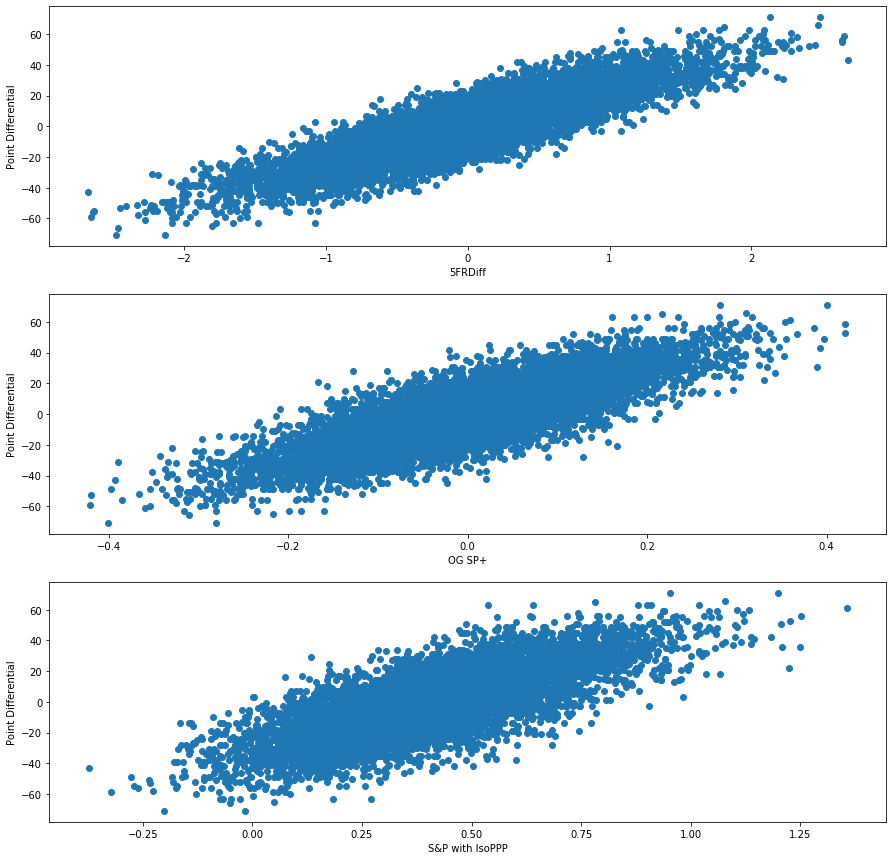

In [17]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [18]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()

In [19]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.905984,0.739098
S&PIsoPPPDiff,0.905984,1.000000,0.799002
PtsDiff,0.739098,0.799002,1.000000


In [20]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,4.968386,4.842944,4.629272,4.134715,4.968386,4.842944,5.291995,0.617590,0.844447,2.041125
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.667805,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.285009,0.603619,0.825343,0.194393
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,-3.471563,-2.354973,-0.969049,-1.381137,-3.471563,-2.354973,4.687991,-0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.824167,-0.351666,0.480841,0.534580


In [21]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [22]:
# outliers

In [23]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,4.968386,4.842944,4.629272,4.134715,4.968386,4.842944,5.291995,0.617590,0.844447,2.041125
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-4.968386,-4.842944,-4.629272,-4.134715,-4.968386,-4.842944,4.667805,-0.617590,0.844447,2.041125
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,3.471563,2.354973,0.969049,1.381137,3.471563,2.354973,5.285009,0.603619,0.825343,0.194393
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,3.498718,3.709156,1.714467,1.340515,3.498718,3.709156,4.824167,-0.351666,0.480841,0.534580
5,Ball State,2012,322432050,37.0,11.0,0.979920,96,0.510417,0.083333,6.291667,...,-3.498718,-3.709156,-1.714467,-1.340515,-3.498718,-3.709156,5.175833,0.351666,0.480841,0.534580


In [24]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [25]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Linear Regression: y = 24.49124x + -0.03282
Mean Pred Score: -0.4511853327083783
Pred Std Dev: 17.929149070576024
Mean Abs Error: 7.775621347124122
Mdn Abs Error: 6.685637657168101
R-squared: 0.7713793954885422
Adj R-squared: 0.7712486056690276



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.745435,0.575155,0.466597,0.783831,0.582570,0.626140,0.983775,0.490960,0.772603,...,-0.140544,-0.153105,-0.158238,-0.113992,-0.140544,-0.153105,-0.158238,0.868811,0.878321,0.878321
OffSRDiff,0.745435,1.000000,0.464464,0.251727,0.676233,0.349323,0.427357,0.743751,0.733858,0.698928,...,-0.098235,-0.106601,-0.109223,-0.086816,-0.098235,-0.106601,-0.109223,0.954968,0.948819,0.948819
OffERDiff,0.575155,0.464464,1.000000,0.155511,0.510389,0.290451,0.344736,0.562647,0.335670,0.804134,...,-0.098190,-0.088753,-0.086523,-0.091279,-0.098190,-0.088753,-0.086523,0.544395,0.541591,0.541591
FPDiff,0.466597,0.251727,0.155511,1.000000,0.587920,0.107200,0.118696,0.446126,0.015967,0.203286,...,-0.018395,-0.038197,-0.060870,0.032253,-0.018395,-0.038197,-0.060870,0.344285,0.358231,0.358231
OppRateDiff,0.783831,0.676233,0.510389,0.587920,1.000000,0.184771,0.223195,0.783191,0.230728,0.650032,...,-0.104177,-0.124398,-0.137723,-0.083957,-0.104177,-0.124398,-0.137723,0.756713,0.761669,0.761669
OppEffDiff,0.582570,0.349323,0.290451,0.107200,0.184771,1.000000,0.743138,0.580152,0.440054,0.433243,...,-0.087805,-0.089036,-0.088790,-0.081385,-0.087805,-0.089036,-0.088790,0.483151,0.493114,0.493114
OppPPDDiff,0.626140,0.427357,0.344736,0.118696,0.223195,0.743138,1.000000,0.633679,0.529843,0.498199,...,-0.105831,-0.118577,-0.117039,-0.088229,-0.105831,-0.118577,-0.117039,0.601362,0.607327,0.607327
PPDDiff,0.983775,0.743751,0.562647,0.446126,0.783191,0.580152,0.633679,1.000000,0.482616,0.765288,...,-0.143304,-0.155618,-0.162158,-0.119789,-0.143304,-0.155618,-0.162158,0.868265,0.876932,0.876932
OppSRDiff,0.490960,0.733858,0.335670,0.015967,0.230728,0.440054,0.529843,0.482616,1.000000,0.528093,...,-0.077510,-0.073707,-0.066175,-0.062805,-0.077510,-0.073707,-0.066175,0.715678,0.707770,0.707770
YPPDiff,0.772603,0.698928,0.804134,0.203286,0.650032,0.433243,0.498199,0.765288,0.528093,1.000000,...,-0.108332,-0.110001,-0.105227,-0.102108,-0.108332,-0.110001,-0.105227,0.785134,0.780971,0.780971


In [26]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.729032,0.745435,0.720864,0.902340,0.702790,0.447712,0.868811,0.878321,0.878321
ActPts,0.729032,1.000000,0.531760,0.499502,0.650995,0.499264,0.304209,0.619736,0.628722,0.628722
Eff,0.745435,0.531760,1.000000,0.628691,0.778319,0.994081,0.281499,0.954968,0.948819,0.948819
Expl,0.720864,0.499502,0.628691,1.000000,0.693107,0.614629,0.238904,0.721038,0.718376,0.718376
FinDrv,0.902340,0.650995,0.778319,0.693107,1.000000,0.745202,0.408367,0.917426,0.922043,0.922043
FldPos,0.702790,0.499264,0.994081,0.614629,0.745202,1.000000,0.215045,0.931671,0.920264,0.920264
Trnovr,0.447712,0.304209,0.281499,0.238904,0.408367,0.215045,1.000000,0.437567,0.422618,0.422618
5FR,0.868811,0.619736,0.954968,0.721038,0.917426,0.931671,0.437567,1.000000,0.996123,0.996123
5FRDiff,0.878321,0.628722,0.948819,0.718376,0.922043,0.920264,0.422618,0.996123,1.000000,1.000000
PredPtsDiff,0.878321,0.628722,0.948819,0.718376,0.922043,0.920264,0.422618,0.996123,1.000000,1.000000


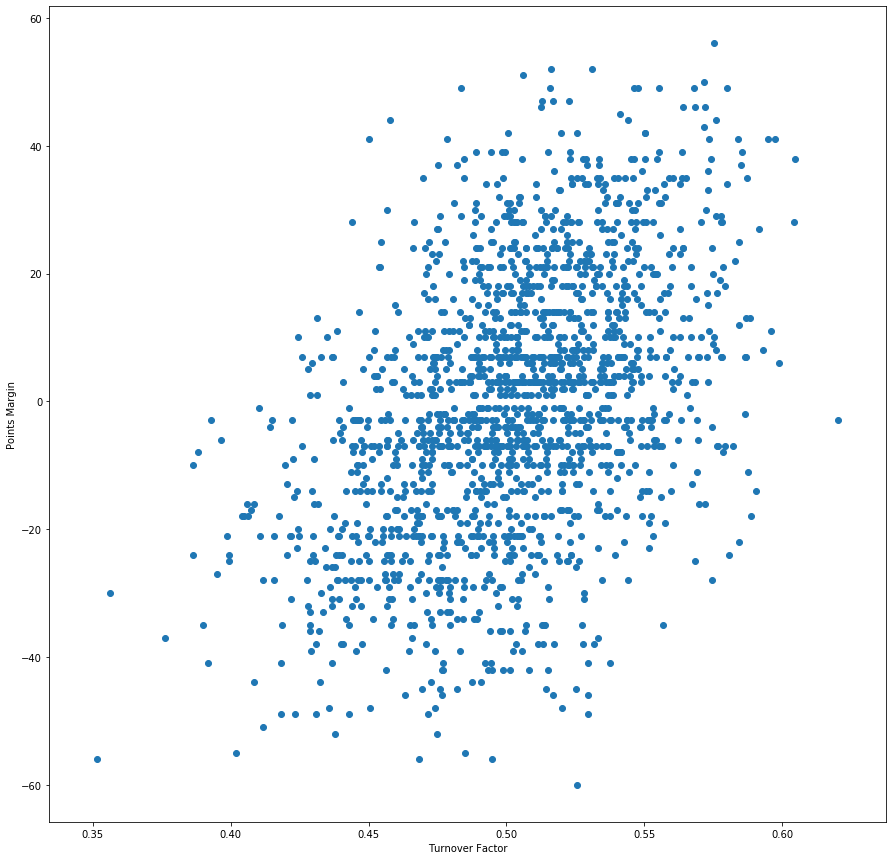

In [27]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

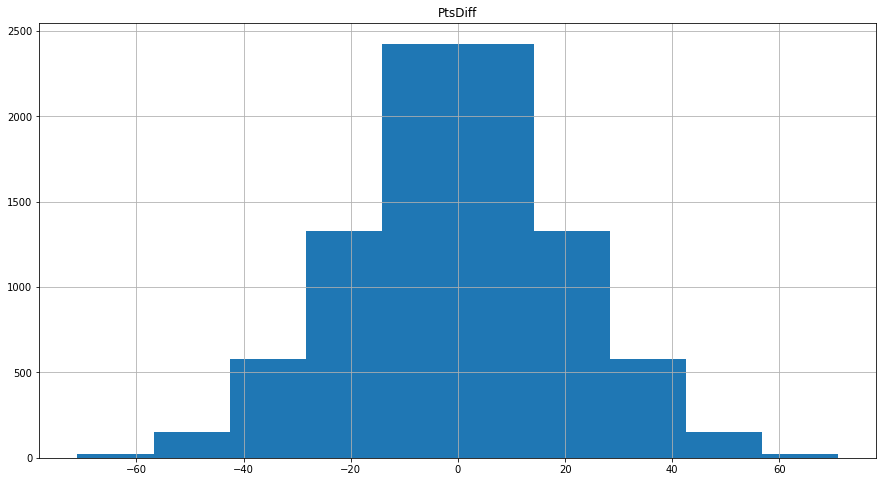

In [28]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

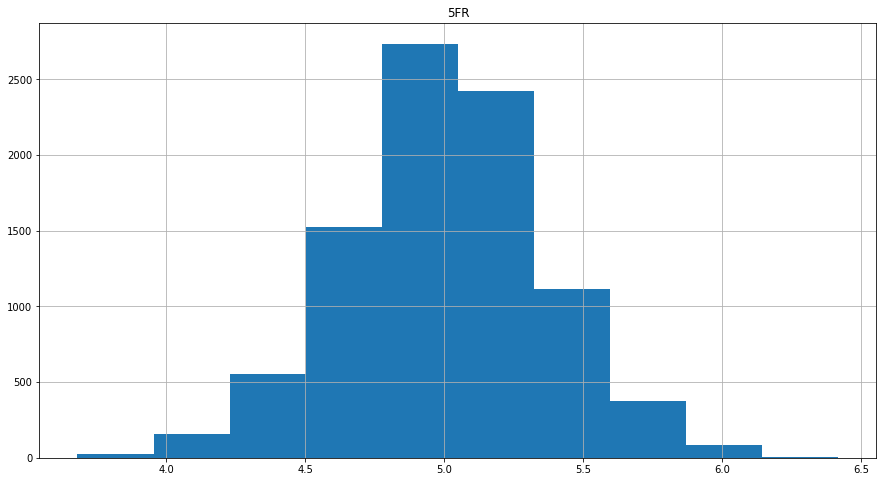

In [29]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

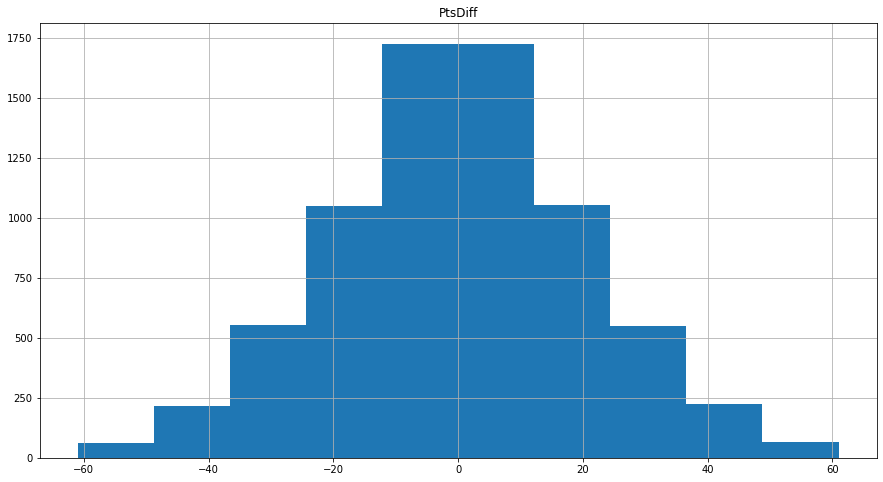

In [30]:
train_data.hist(column='PtsDiff', figsize=(15,8));

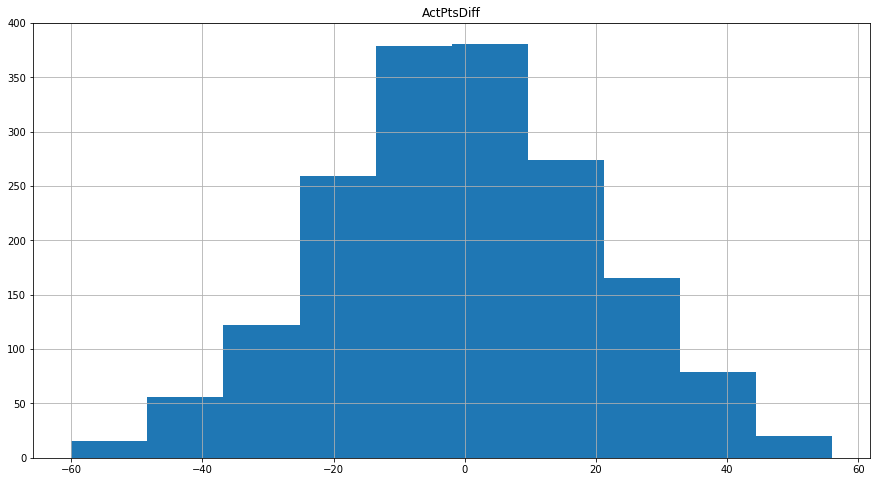

In [31]:
test.hist(column='ActPtsDiff', figsize=(15,8));

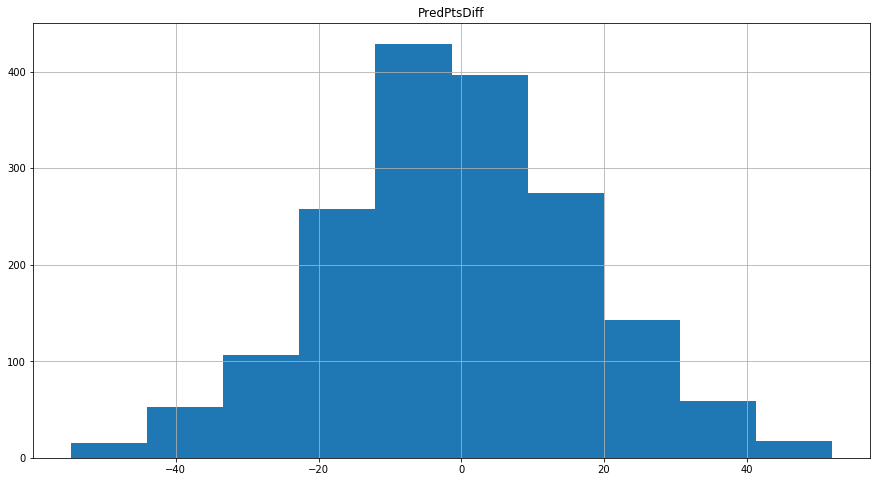

In [32]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [33]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [34]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5.0 (exact value: -5.054366036509569)
Z score: -0.2567428429358974
Win Prob for Virginia Tech: 39.87%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.574919,-1.574919,-0.181874,0.5748,1.574919,1.574919,-0.181874,0.5748,5.101903,0.205034
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.574919,1.574919,0.181874,-0.5748,-1.574919,-1.574919,0.181874,-0.5748,4.896869,-0.205034


In [35]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -1.0 (exact value: -1.1048500126178176)
Z score: -0.03645820988694799
Win Prob for Georgia Tech: 48.55%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,63,0.396825,0.111111,5.460317,...,-0.999132,-1.896154,-1.234875,-1.17414,0.999132,1.896154,-1.234875,-1.17414,5.000913,-0.043772
1,Miami,2019,401112488,21.0,-7.0,0.934248,62,0.370968,0.112903,5.790323,...,0.999132,1.896154,1.234875,1.17414,-0.999132,-1.896154,1.234875,1.17414,5.044685,0.043772


In [36]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -2.0 (exact value: -1.5758124175146841)
Z score: -0.06272618295376658
Win Prob for Georgia Tech: 47.50%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,80,0.487500,0.150000,5.712500,...,-0.947104,-1.520453,-0.222096,-0.222096,0.947104,1.520453,-0.222096,-0.222096,5.030954,0.063002
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,57,0.473684,0.140351,7.035088,...,0.947104,1.520453,0.222096,0.222096,-0.947104,-1.520453,0.222096,0.222096,4.967952,-0.063002


In [37]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 1.0 (exact value: 0.8949729841296011)
Z score: 0.07508210855623894
Win Prob for Mississippi State: 52.99%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,71,0.422535,0.070423,5.563380,...,-1.009373,-0.990326,1.338368,1.402505,1.009373,0.990326,1.338368,1.402505,4.968742,-0.037883
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,58,0.413793,0.137931,5.482759,...,1.009373,0.990326,-1.338368,-1.402505,-1.009373,-0.990326,-1.338368,-1.402505,5.006625,0.037883


In [38]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3.0 (exact value: -3.372756105497682)
Z score: -0.16295088859425944
Win Prob for Texas A&M: 43.53%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,90,0.466667,0.088889,5.511111,...,-1.571744,-1.582803,1.105475,1.785905,1.571744,1.582803,1.105475,1.785905,5.067879,0.136373
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,104,0.423077,0.105769,4.634615,...,1.571744,1.582803,-1.105475,-1.785905,-1.571744,-1.582803,-1.105475,-1.785905,4.931506,-0.136373


In [39]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.951197,13,12.0,1.0
2,LSU,0.945458,13,12.0,1.0
3,Alabama,0.922357,12,11.0,1.0
4,Oklahoma,0.891309,13,12.0,1.0
5,Clemson,0.889594,13,12.0,1.0
6,Navy,0.850304,12,10.0,2.0
7,Utah,0.846688,13,11.0,2.0
8,Buffalo,0.830039,12,10.0,2.0
9,Oregon,0.821091,13,11.0,2.0
10,Minnesota,0.814012,12,10.0,2.0


In [40]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,10.690016,2.309984
53,LSU,9.901600,3.098400
78,Oklahoma,9.016201,3.983799
115,Utah,8.300654,4.699346
34,Georgia,7.593436,5.406564
11,Baylor,7.389872,5.610128
82,Oregon,7.238976,5.761024
3,Appalachian State,7.192865,5.807135
56,Memphis,7.180942,5.819058
91,SMU,6.900645,5.099355


In [41]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Florida State,2012,5.457738,1
1,Arizona State,2012,5.334085,2
2,Alabama,2012,5.281100,3
3,Boise State,2012,5.278873,4
4,Georgia,2012,5.248065,5
5,Fresno State,2012,5.246787,6
6,Oklahoma,2012,5.246374,7
7,Ohio State,2012,5.214594,8
8,Bowling Green,2012,5.210617,9
9,Michigan State,2012,5.188836,10


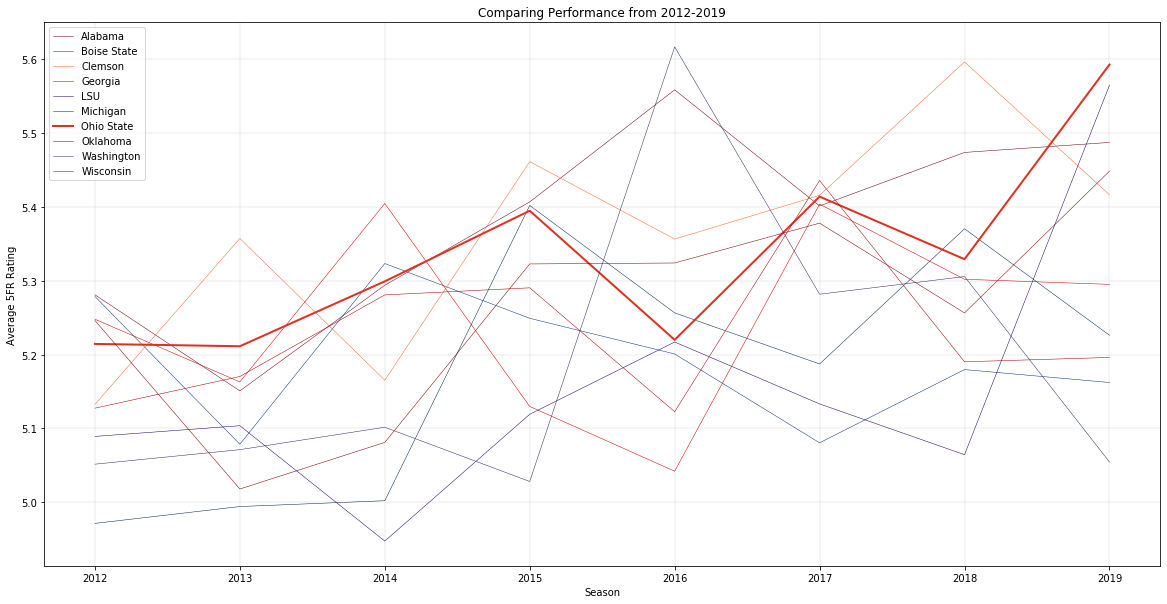

In [42]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [43]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.381899
1,Clemson,5.362864
2,Ohio State,5.334643
3,Oklahoma,5.259524
4,Georgia,5.248675
5,Wisconsin,5.226861
6,Boise State,5.194265
7,Washington,5.189033
8,Western Kentucky,5.184650
9,Michigan,5.176372


In [44]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
508,Washington,2016,5.617003,1
766,Clemson,2018,5.596648,1
896,Ohio State,2019,5.593035,1
125,Florida State,2013,5.584788,1
897,LSU,2019,5.565156,2
509,Alabama,2016,5.558865,2
510,Louisville,2016,5.505334,3
767,NC State,2018,5.487608,2
898,Alabama,2019,5.487596,3
768,Alabama,2018,5.474043,3


In [45]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
287,Georgia Tech,2014,5.121145,36
695,Georgia Tech,2017,5.035943,60
63,Georgia Tech,2012,4.986985,64
187,Georgia Tech,2013,4.973355,63
582,Georgia Tech,2016,4.950238,75
467,Georgia Tech,2015,4.884755,88
998,Georgia Tech,2019,4.837645,103
881,Georgia Tech,2018,4.744622,116


In [46]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322872751.0,Wyoming,2012.0,Air Force,4.0
4,322942005.0,New Mexico,2012.0,Air Force,5.0
5,323290278.0,Fresno State,2012.0,Air Force,6.0
6,332502005.0,Utah State,2013.0,Air Force,1.0
7,332642005.0,Wyoming,2013.0,Air Force,2.0
8,332712440.0,Nevada,2013.0,Air Force,3.0
9,332782426.0,Navy,2013.0,Air Force,4.0


In [114]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if ((team1_conf != "FBS Independents") & (team2_conf != "FBS Independents")):
        if (team2_conf_sos < team1_conf_sos):
            team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
        elif (team2_conf_sos > team1_conf_sos):
            team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)

    if (week == 0):
        # adjust by team talent    
        if (team2_talent < team1_talent):
            team2_avg_ffr *= (team2_talent / team1_talent)
        elif (team2_talent > team1_talent):
            team1_avg_ffr *= (team1_talent / team2_talent)
        
        # adjust by returning production
        team1_avg_ffr *= (team1_talent / team1_old_talent)
        team2_avg_ffr *= (team2_talent / team2_old_talent)
#         print("preseason")
#         print(team1, team1_talent)
#         print(team2, team2_talent)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += 2.5
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2020, 0, -1, True)

[0.15213198136969797, -18.870381387783038]

In [115]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,home_point_diff,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick,ml_win,ats_win
0,Buffalo,Charlotte,7.0,24,6.285155,0.646437,False,Buffalo,Charlotte,Buffalo,Buffalo
0,Utah State,Kent State,7.0,-10,3.922035,0.596352,False,Utah State,Kent State,Kent State,Kent State
0,San Diego State,Central Michigan,3.5,37,-4.349220,0.413943,False,Central Michigan,Central Michigan,San Diego State,San Diego State
0,Georgia Southern,Liberty,4.5,-7,2.074531,0.556014,False,Georgia Southern,Liberty,Liberty,Liberty
0,SMU,Florida Atlantic,7.0,-14,-10.253287,0.292288,False,Florida Atlantic,Florida Atlantic,Florida Atlantic,Florida Atlantic
0,Florida International,Arkansas State,1.0,-6,-5.577445,0.387471,False,Arkansas State,Arkansas State,Arkansas State,Arkansas State
0,Washington,Boise State,3.5,31,-0.968864,0.488483,False,Boise State,Boise State,Washington,Washington
0,Appalachian State,UAB,17.0,14,7.555314,0.672405,False,Appalachian State,UAB,Appalachian State,UAB
0,UCF,Marshall,15.0,23,7.341773,0.668093,False,UCF,Marshall,UCF,UCF
0,BYU,Hawai'i,2.0,-4,1.555899,0.544567,False,BYU,Hawai'i,Hawai'i,Hawai'i


In [116]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 20-20
ML Record: 26-14


In [117]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 1.0 (exact value: 1.2585481939980507)
Z score: 0.09536055057472391
Win Prob for Virginia: 53.80%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,74,0.432432,0.162162,6.540541,...,-0.701916,-1.148732,1.8973,1.493764,0.701916,1.148732,1.8973,1.493764,4.953163,-0.052728
1,Virginia,2019,401112521,39.0,9.0,0.422744,55,0.381818,0.181818,8.872727,...,0.701916,1.148732,-1.8973,-1.493764,-0.701916,-1.148732,-1.8973,-1.493764,5.005890,0.052728


In [118]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 9.0 (exact value: 8.913538211971634)
Z score: 0.522318349176353
Win Prob for North Carolina: 69.93%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,94,0.457447,0.106383,5.744681,...,-1.158929,-1.683796,0.766883,1.773056,1.158929,1.683796,0.766883,1.773056,5.193487,0.365288
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,53,0.396226,0.150943,6.094340,...,1.158929,1.683796,-0.766883,-1.773056,-1.158929,-1.683796,-0.766883,-1.773056,4.828199,-0.365288


In [119]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 20.0 (exact value: 19.646250030830483)
Z score: 1.120936374862389
Win Prob for Pittsburgh: 86.88%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,69,0.362319,0.057971,5.086957,...,-0.046428,-0.046428,-0.64851,-0.243034,0.046428,0.046428,-0.64851,-0.243034,5.384026,0.803515
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,49,0.204082,0.061224,3.591837,...,0.046428,0.046428,0.64851,0.243034,-0.046428,-0.046428,0.64851,0.243034,4.580512,-0.803515


In [120]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -12.0 (exact value: -12.46489946831504)
Z score: -0.6700660521208264
Win Prob for Auburn: 25.14%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,75,0.453333,0.133333,6.440000,...,0.635533,-0.646963,-1.70793,-1.525407,-0.635533,0.646963,-1.70793,-1.525407,5.244792,0.507613
1,Auburn,2019,401110865,48.0,3.0,0.599891,62,0.338710,0.112903,5.322581,...,-0.635533,0.646963,1.70793,1.525407,0.635533,-0.646963,1.70793,1.525407,4.737179,-0.507613


In [121]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 35.0 (exact value: 34.78335055184482)
Z score: 1.9652096006261377
Win Prob for Georgia: 97.53%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,72,0.472222,0.138889,6.847222,...,1.909013,NaN,1.691637,1.601396,-1.909013,-4.32647,1.691637,1.601396,5.724853,1.421577
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,58,0.224138,0.034483,2.396552,...,-1.909013,NaN,-1.691637,-1.601396,1.909013,4.32647,-1.691637,-1.601396,4.303276,-1.421577


In [122]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_prediction_prob(row):
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.Index, 4,(row.Site != "Neutral"))[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov(row):
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.Index, 4, (row.Site != "Neutral"))[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def determine_site(row):
    if (row.NeutralSite):
        return "Neutral"
    elif (row.HomeTeam == row.Team):
        return "Home"
    else:
        return "Away"
    
    
def generate_schedule_analysis(team, year = 2019):
    gms = games[(games.year == year) & ((games.away_team == team) | (games.home_team == team))]
    frame = pd.DataFrame(data={"GameID":gms.id,"Year":year,"Team":team,"AwayTeam":gms.away_team,"HomeTeam":gms.home_team,"NeutralSite":gms.neutral_site})
    frame.reset_index(inplace=True, drop=True)
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['Site'] = frame.apply(lambda y: determine_site(y), axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame[["GameID","Year","Team","Opponent","Site","PredMOV","PredWinProb","ActualMOV","PostGameWinProb"]]

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 20.0 (exact value: 20.444356935163224)
Z score: 1.1654508635975256
Win Prob for Clemson: 87.81%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 12.0 (exact value: 11.5937301059766)
Z score: 0.6718063077768812
Win Prob for Georgia Tech: 74.91%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -5.0 (exact value: -4.953422479016309)
Z score: -0.2511127063858633
Win Prob for The Citadel: 40.09%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 19.0 (exact value: 19.021929853939014)
Z score: 1.0861148574309758
Win Prob for Temple: 86.13%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 9.0 (exact value: 8.913538211971634)
Z score: 0.522318349176353


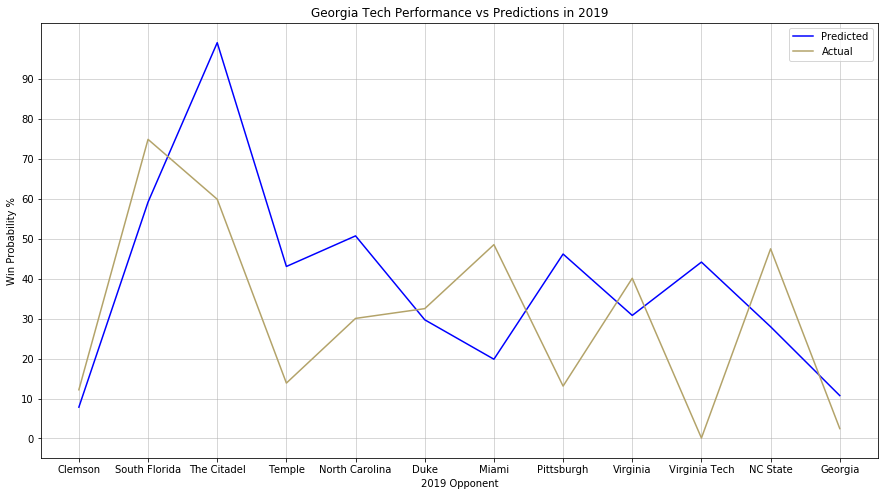

In [123]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

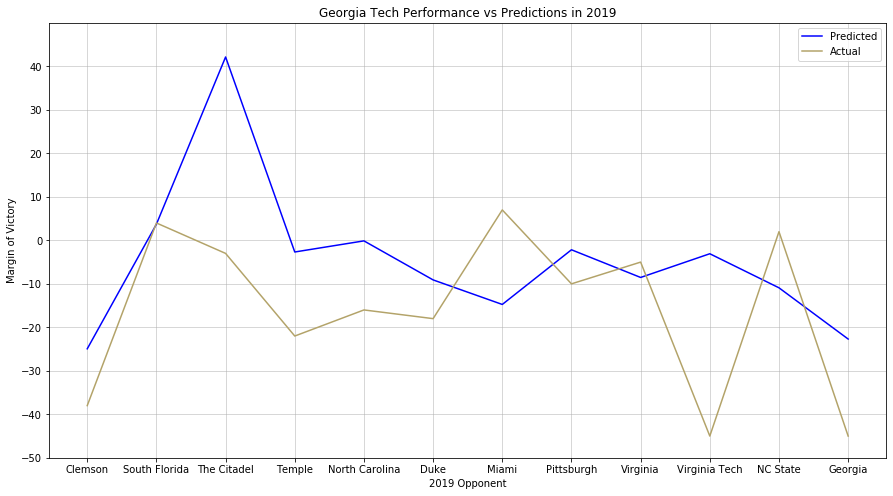

In [124]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 39.995160278201986)
Z score: 2.255898785363321
Win Prob for Georgia Tech: 98.80%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by -3.0 (exact value: -2.608493924921728)
Z score: -0.12032409255572328
Win Prob for South Florida: 45.21%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 4.0 (exact value: 3.6261265935643077)
Z score: 0.2274124616970286
Win Prob for Pittsburgh: 58.99%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 39.0 (exact value: 39.05066611497972)
Z score: 2.2032195332970694
Win Prob for Clemson: 98.62%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 37.0 (exact value: 36.61827187753226)
Z s

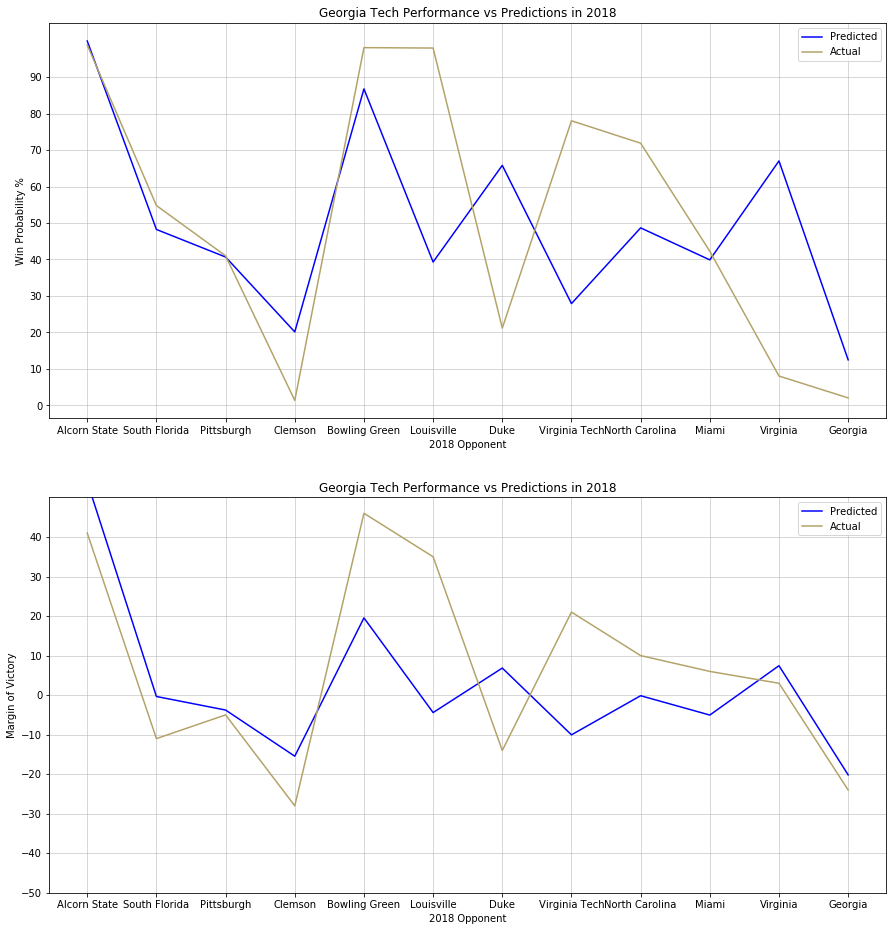

In [125]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

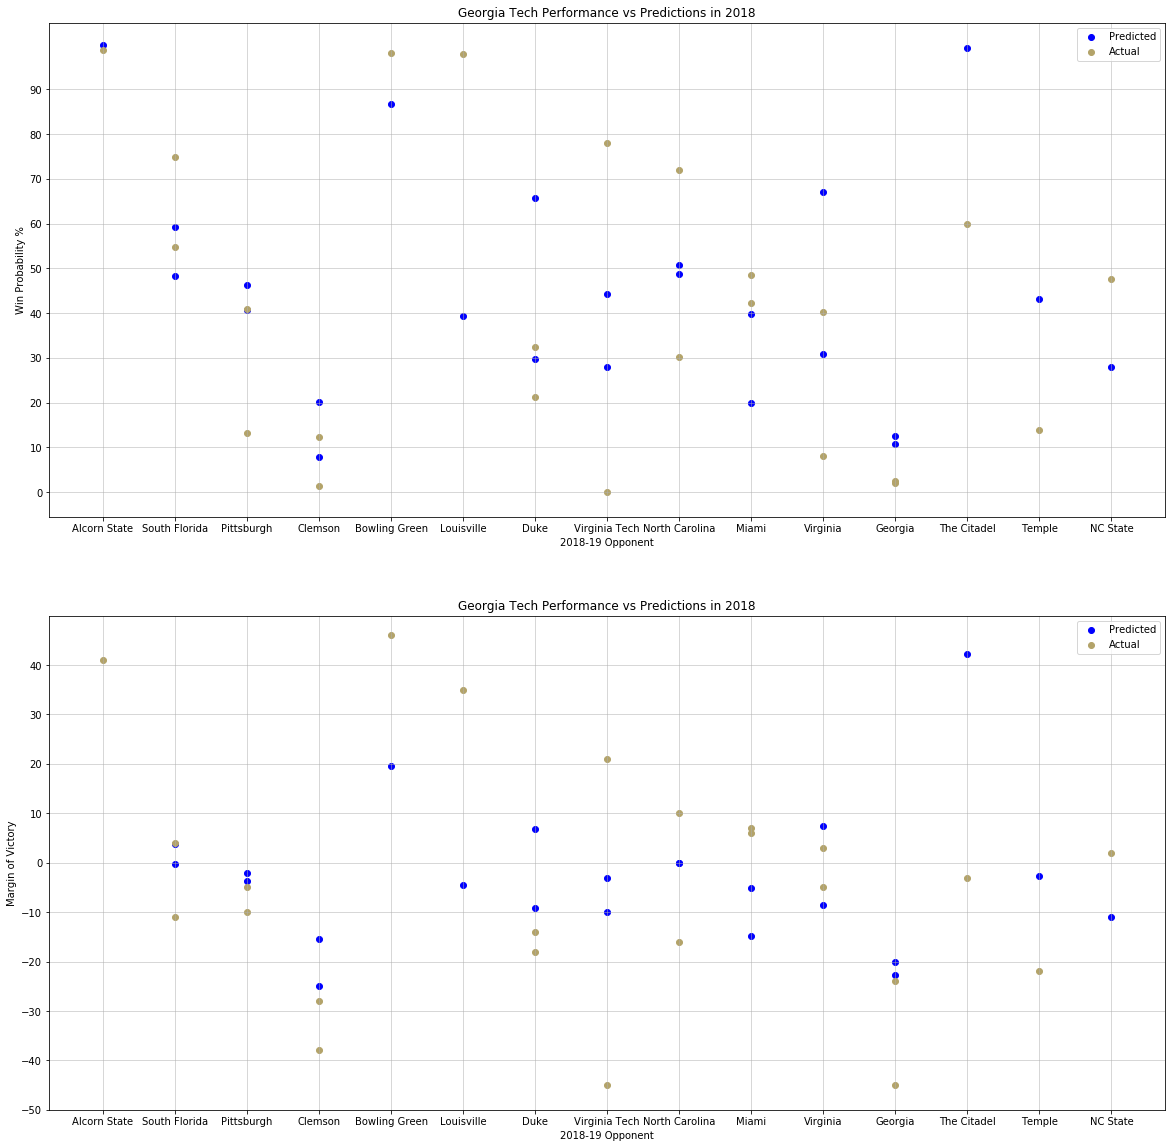

In [126]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [127]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.614825,0.411864,0.357095,0.287520,0.226350,0.206436,0.320704
2013,0.614825,1.000000,0.457448,0.301335,0.172779,0.224508,0.135427,0.293300
2014,0.411864,0.457448,1.000000,0.491216,0.320968,0.256653,0.273812,0.265809
2015,0.357095,0.301335,0.491216,1.000000,0.542382,0.421031,0.295558,0.334295
2016,0.287520,0.172779,0.320968,0.542382,1.000000,0.444560,0.310985,0.432926
2017,0.226350,0.224508,0.256653,0.421031,0.444560,1.000000,0.565964,0.392912
2018,0.206436,0.135427,0.273812,0.295558,0.310985,0.565964,1.000000,0.465453
2019,0.320704,0.293300,0.265809,0.334295,0.432926,0.392912,0.465453,1.000000


In [149]:
def round_sig_figs(i, n):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"))[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"))[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Clemson","Gardner-Webb","UCF","North Carolina","Virginia Tech","Virginia","Pittsburgh","Syracuse","Duke","Notre Dame","Miami","Georgia"],
    "Site" : ["Home","Home","Home","Away","Away","Home","Away","Away","Home","Neutral","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
# georgia_tech_2020.to_csv("results/gt-2020.csv", index=False, sep=",")
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Clemson,Home,15.213198,-18.870381
1,2020,Georgia Tech,Gardner-Webb,Home,99.932345,57.002279
2,2020,Georgia Tech,UCF,Home,48.040581,-1.332136
3,2020,Georgia Tech,North Carolina,Away,25.363023,-11.437803
4,2020,Georgia Tech,Virginia Tech,Away,30.263885,-8.815063
5,2020,Georgia Tech,Virginia,Home,46.570884,-1.994191
6,2020,Georgia Tech,Pittsburgh,Away,32.155076,-7.856586
7,2020,Georgia Tech,Syracuse,Away,45.751270,-1.461891
8,2020,Georgia Tech,Duke,Home,55.046944,1.823082
9,2020,Georgia Tech,Notre Dame,Neutral,23.143254,-13.613642


In [129]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [130]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [131]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 535 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 530 games with betting lines for 2013 season.
[Simulation] Creating projections for 530 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 528 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 488 games with betting lines for 2014 season.
[Simulation] Creating projections for 488 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 570 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 542 games with betting lines for 2015 season.
[Simulation] Creating projections for 542 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,396,134,0,0.747170
1,ATS,2013,295,228,7,0.556604
0,ML,2014,374,114,0,0.766393
1,ATS,2014,302,177,9,0.618852
0,ML,2015,425,117,0,0.784133
1,ATS,2015,337,191,14,0.621771
0,ML,2016,420,119,0,0.779221
1,ATS,2016,332,193,14,0.615955
0,ML,2017,448,157,0,0.740496
1,ATS,2017,338,249,18,0.558678


In [132]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2019) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2019) if betting $5 per game: $3068.0


,pick_category,season,W,L,D,WinPct,total_invested,net_payout,avg_weekly_payout,pct_return
1,ATS,2013,295,228,7,0.556604,2650,221.0,13.812500,0.083396
1,ATS,2014,302,177,9,0.618852,2440,536.5,33.531250,0.219877
1,ATS,2015,337,191,14,0.621771,2710,634.5,42.300000,0.234133
1,ATS,2016,332,193,14,0.615955,2695,598.5,39.900000,0.222078
1,ATS,2017,338,249,18,0.558678,3025,320.5,21.366667,0.105950
1,ATS,2018,303,216,16,0.566355,2675,327.0,21.800000,0.122243
1,ATS,2019,347,237,10,0.584175,2970,431.5,28.766667,0.145286


In [133]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7683400967230292
Avg ATS Win %: 0.5889129762463171


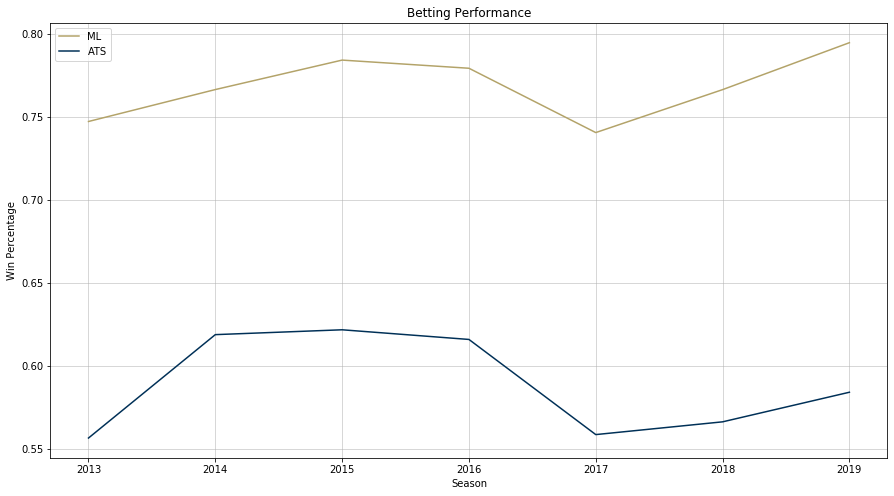

In [134]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

In [135]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [136]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.7164386892001272, 9.809564195434202]

In [137]:
generate_win_prob(401135295, 2019)

Could not find basic game data for game_id 401135295 locally, checking CFB Data API
Could not find drive data for game_id 401135295 locally, checking CFB Data API
Could not find play by play data for game_id 401135295 locally, checking CFB Data API
Game: Clemson @ LSU
Actual Winner: LSU
MOV: LSU by 17
Proj MOV: LSU by 16.0 (exact value: 15.784375400309903)
Z score: 0.9055399488904282
Win Prob for LSU: 81.74%
---


[0.8174102970319765, 17]

In [138]:
# Rankings data
rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [139]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

,Team,5FRSRS,5FRSRSRank
53,LSU,1.503016,1
2,Alabama,1.219208,2
77,Ohio State,1.131691,3
78,Oklahoma,0.934363,4
34,Georgia,0.900267,5
9,Auburn,0.866685,6
21,Clemson,0.860376,7
82,Oregon,0.807358,8
114,Utah,0.783047,9
29,Florida,0.740015,10
